In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import pandas as pd
import random
import scipy.signal as ss
import sys

import tools.data_reader_wesad as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing

from scipy.fft import fft, fftfreq, fftshift
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)


phases = dr.Phases.PHASE_ORDER


In [ ]:
# VISUALIZE STAI LABELS
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

phases = dr.Phases.PHASE_ORDER

stai_scores = dr.get_stai_scores()
columns = stai_scores.columns

dim_scores_valence = dr.get_dim_scores(dim_type="valence")
dim_scores_arousal = dr.get_dim_scores(dim_type="arousal")

# print(stai_scores.head())
# print(dim_scores_valence.head())
# print(dim_scores_arousal.head())

for i in range(stai_scores.shape[0]):
    s = stai_scores.iloc[i, 0]
    stai = stai_scores.iloc[i, 1:]
    valence = dim_scores_valence.iloc[i, 1:]
    arousal = dim_scores_arousal.iloc[i, 1:]
    legend = ["STAI", "Valence", "Arousal"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex="col")
    ax1.plot(stai)
    ax1.set_title(f"STAI, subject {s}")
    ax2.plot(valence)
    ax2.plot(arousal)
    ax2.set_title(f"Valence & arousal, subject {s}")
    ax2.legend(["Valence", "Arousal"])


In [39]:
# HELPER METHODS
import samplerate
import scipy

def get_time_segments(subject, sr_to_convert=0):
    data = dr.get_participant_data(subject)
    labels = data["label"]
    if sr_to_convert > 0:
        step = int(700/sr_to_convert)
        resampled = []
        for i in range(0, labels.size, step):
            resampled.append(labels[i])
        labels = np.asarray(resampled)
        # labels = samplerate.resample(labels, sr_to_convert/700.0)
        # labels = scipy.signal.decimate(labels, int(700.0/sr_to_convert))
    curr_value = labels[0]
    start_indices = [0]
    end_indices = []
    i = 1
    while i < len(labels):
        if labels[i] != curr_value:
            end_indices.append(i-1)
            start_indices.append(i)
            curr_value = labels[i]
        i += 1

    end_indices.append(len(labels)-1)

    time_segments = {}
    for i in range(len(start_indices)):
        label = labels[start_indices[i]]
        if label not in time_segments.keys():
            time_segments[label] = [(start_indices[i], end_indices[i])]
        else:
            time_segments[label].append((start_indices[i], end_indices[i]))
    return time_segments


# ts = get_time_segments(2)
# print(ts)

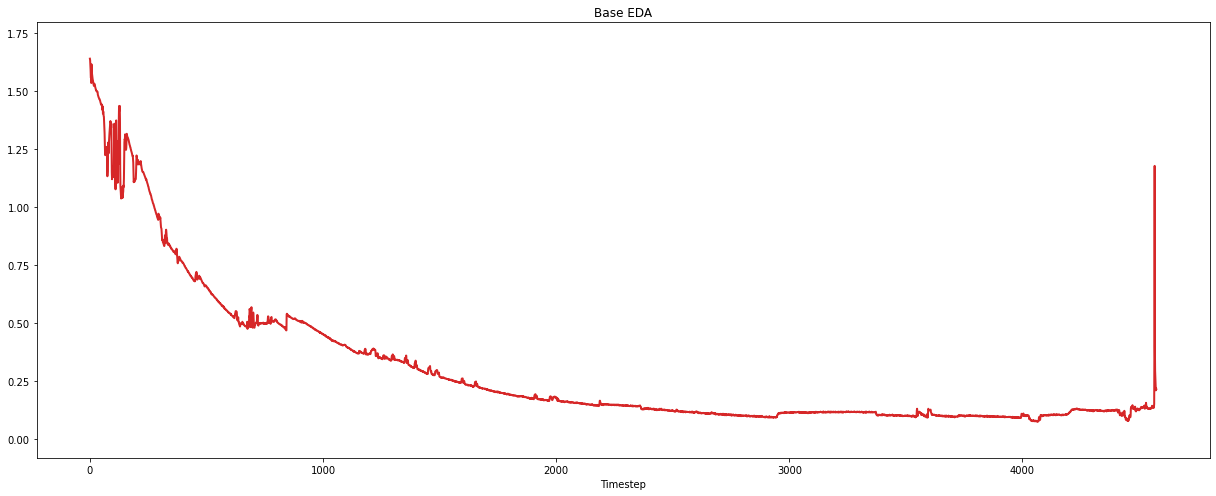

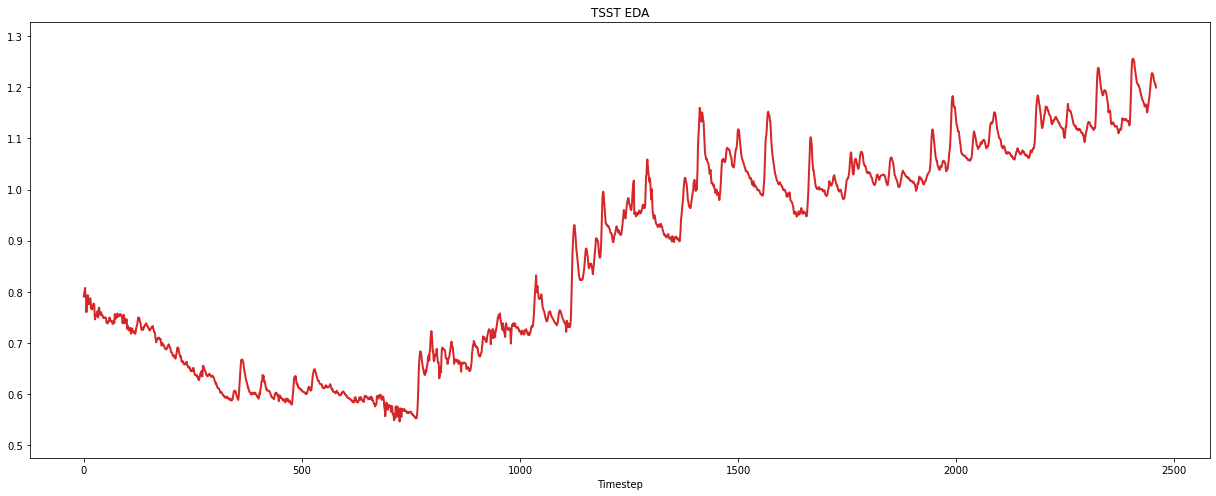

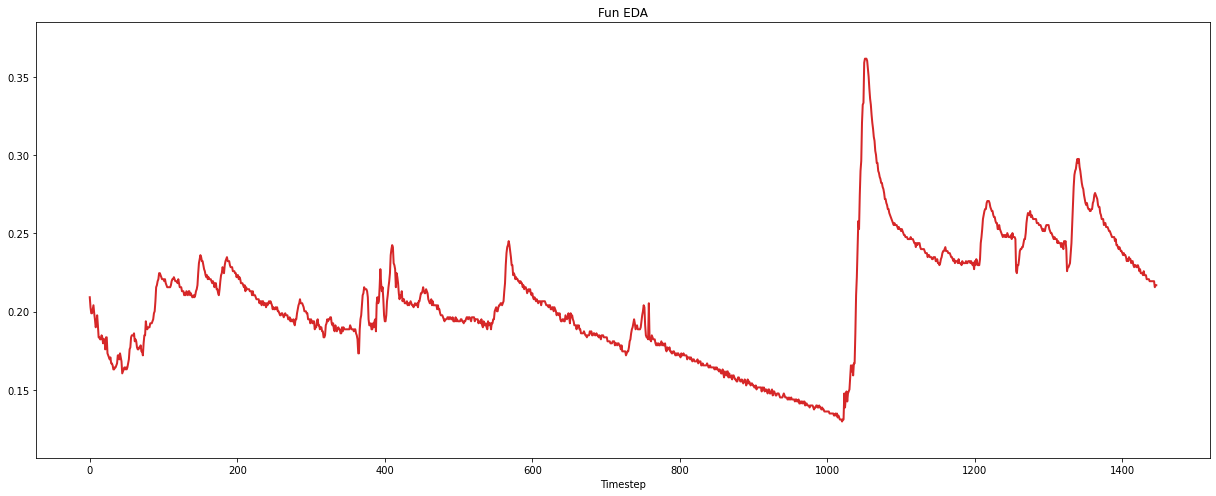

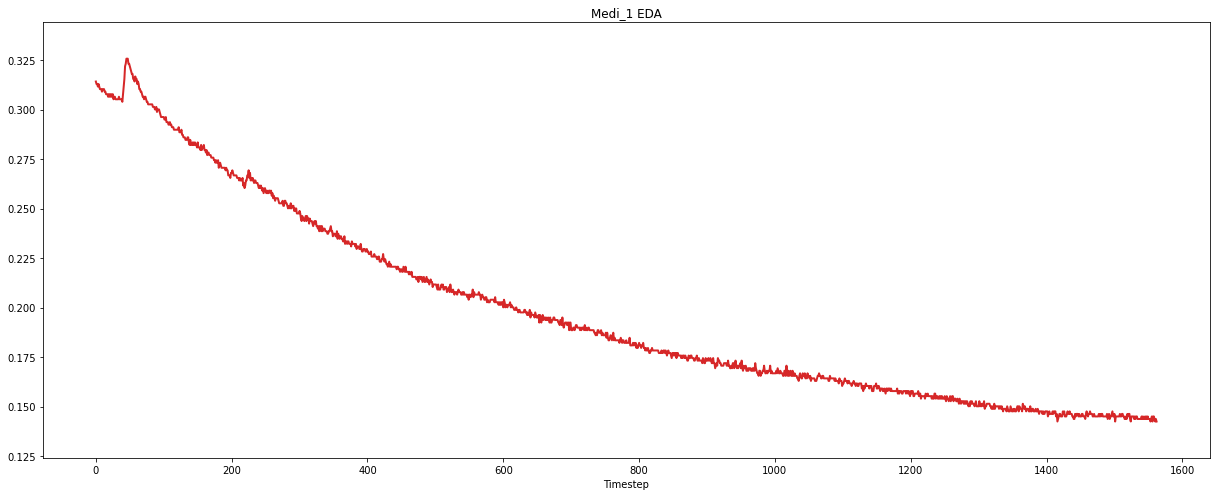

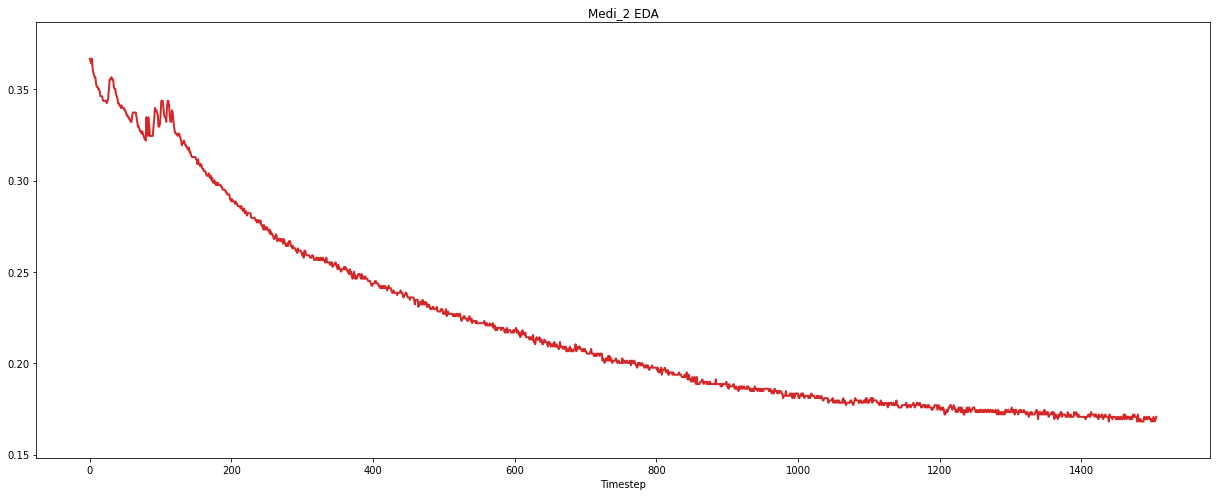

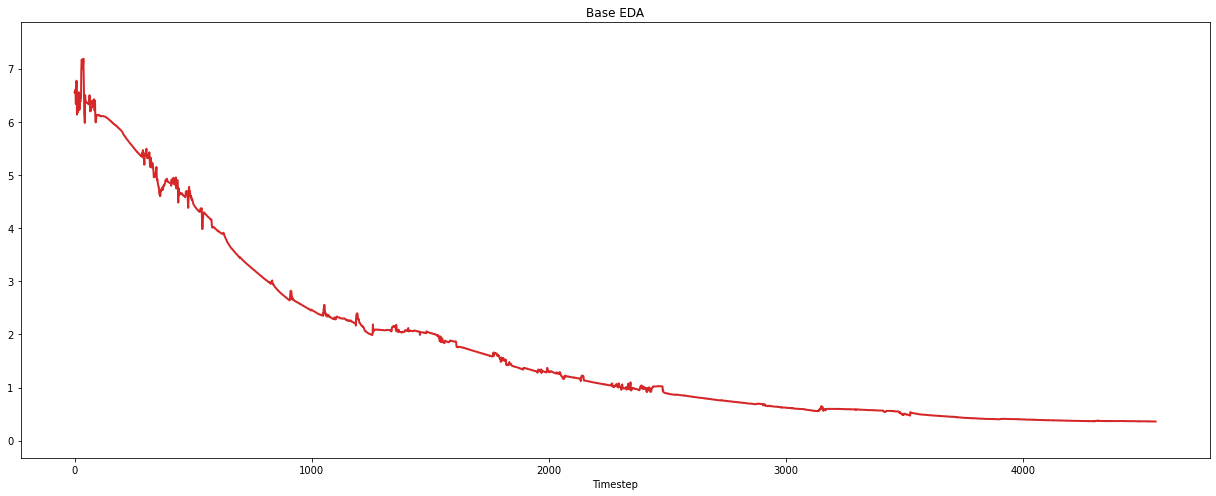

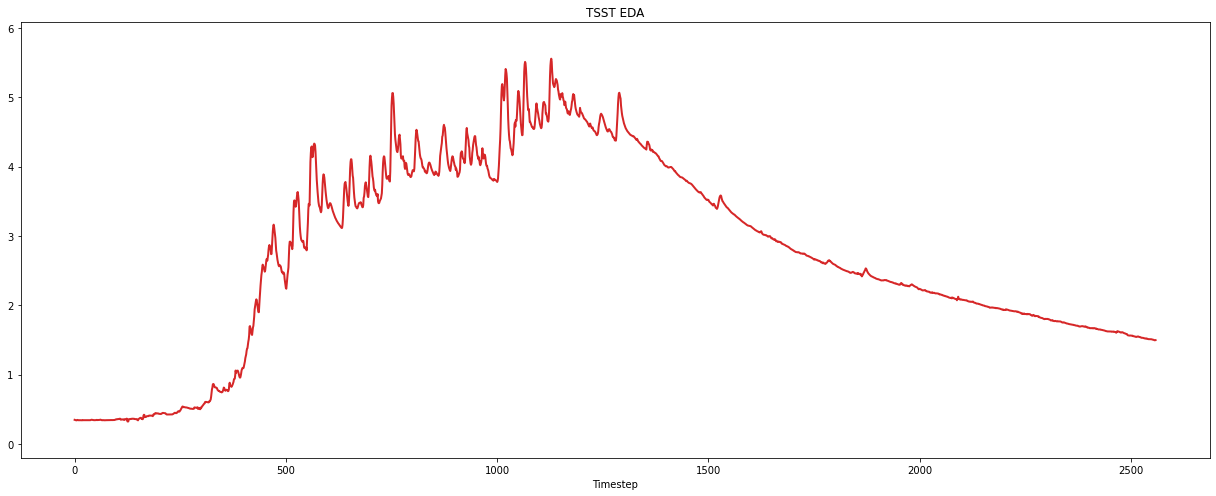

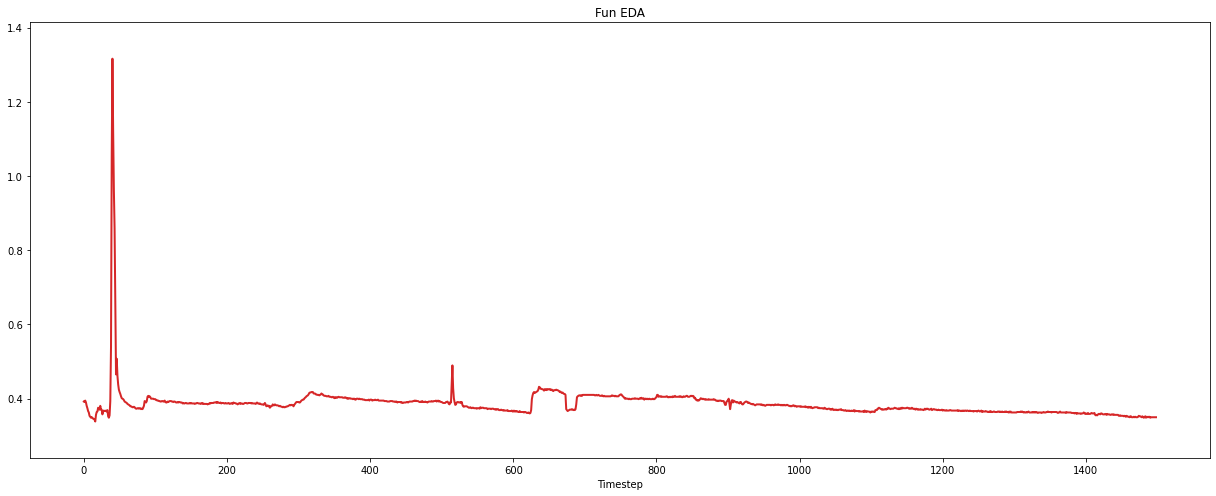

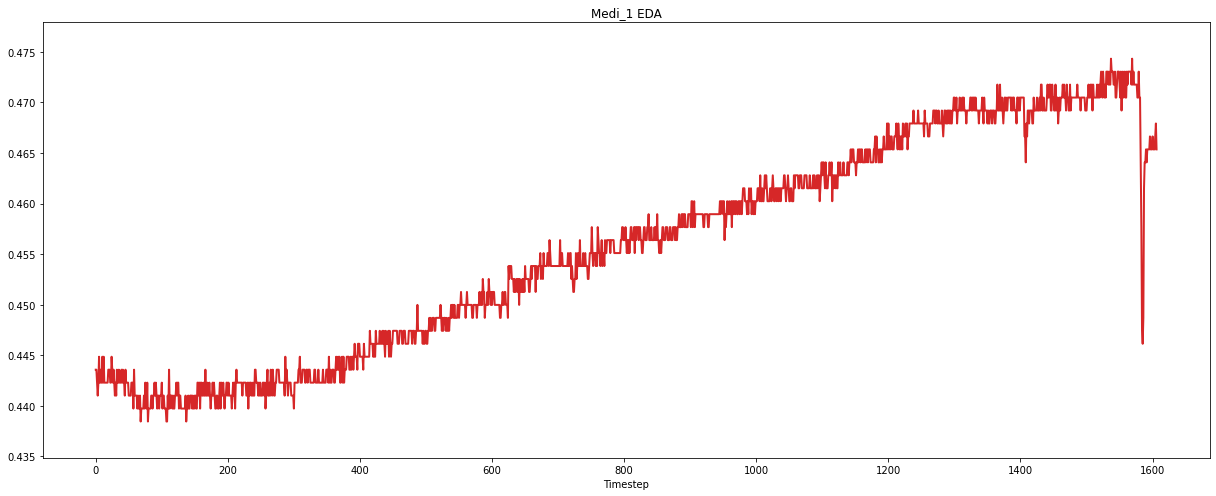

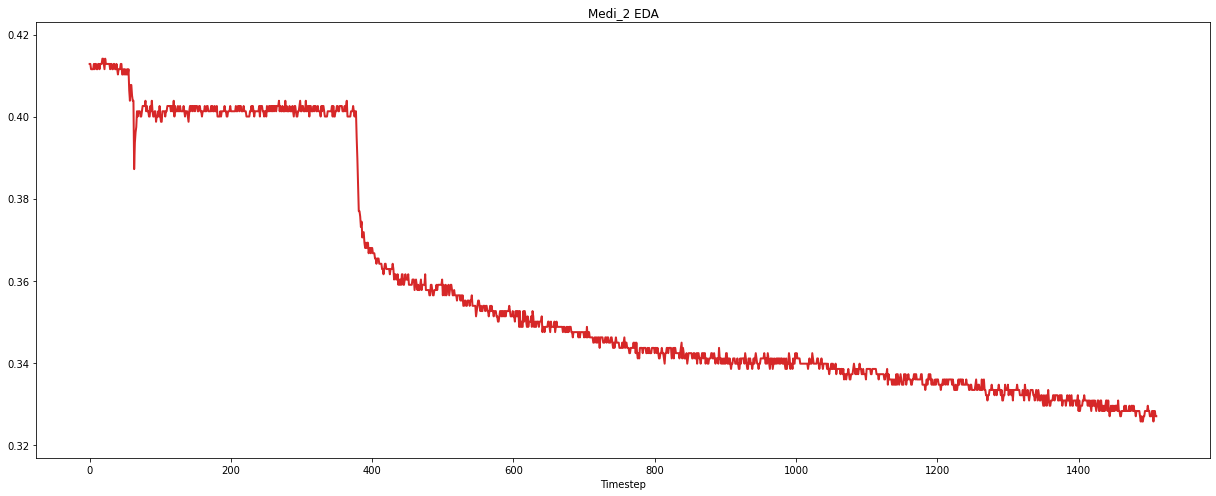

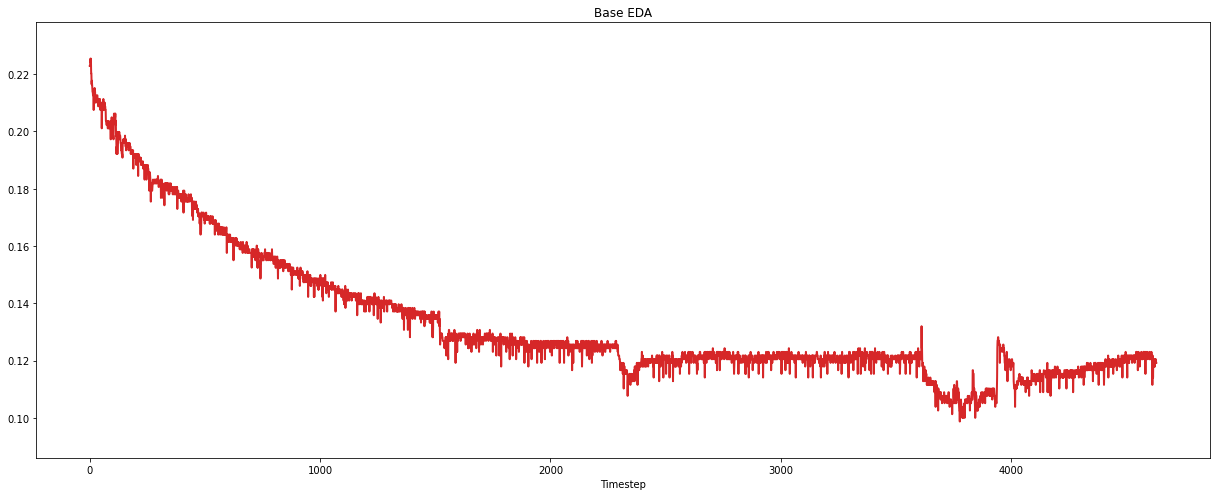

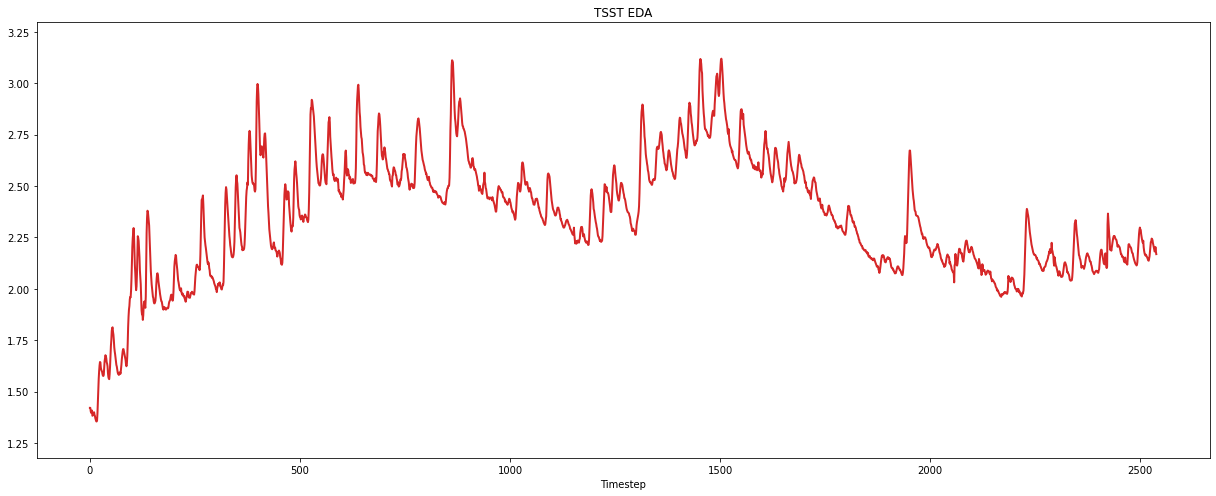

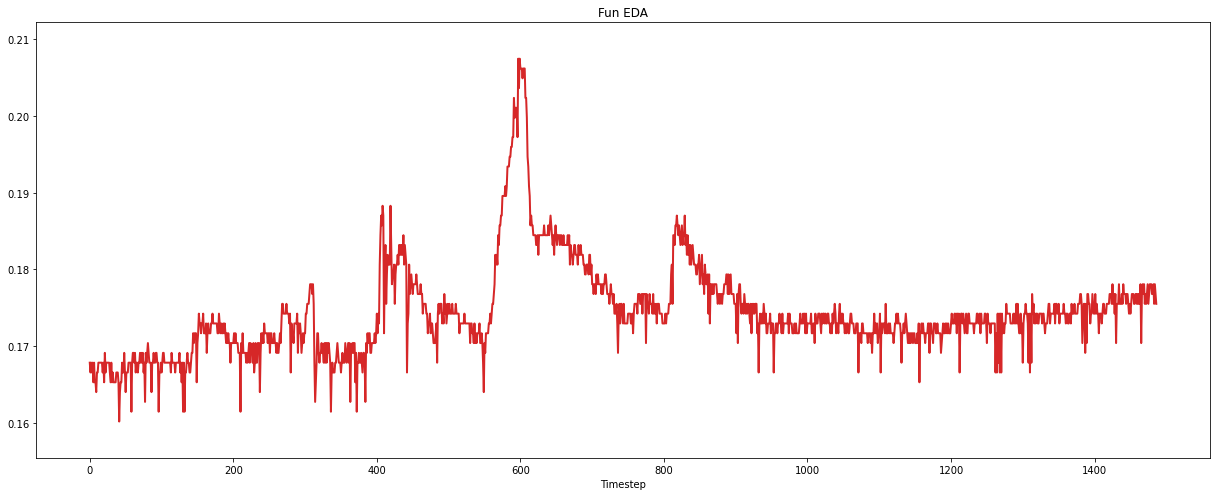

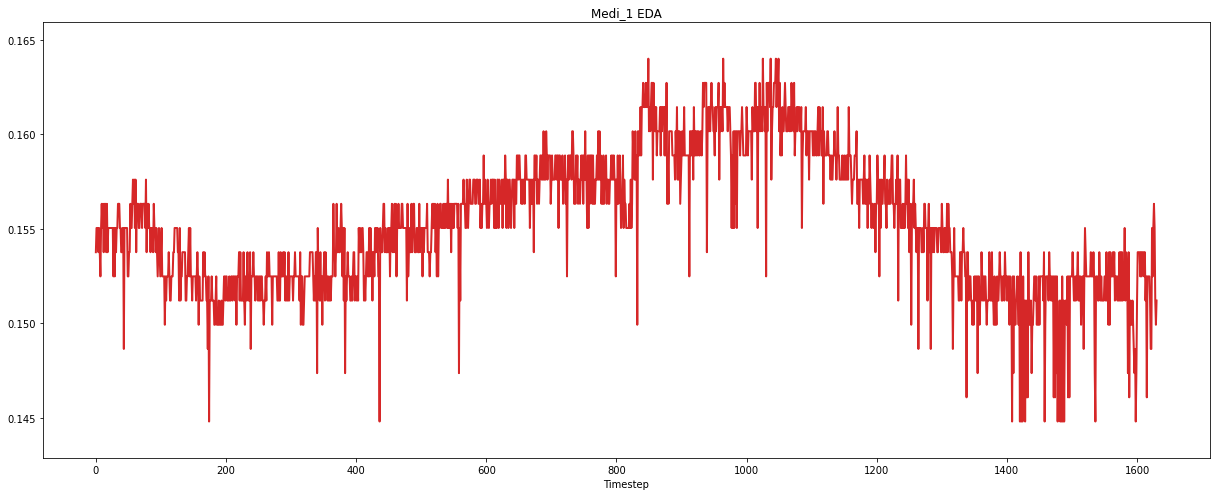

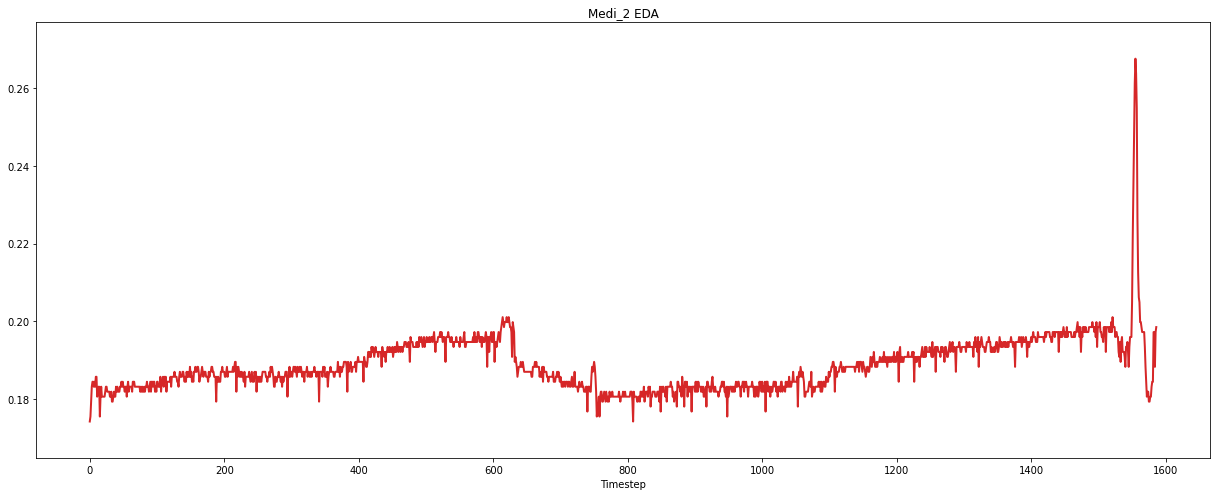

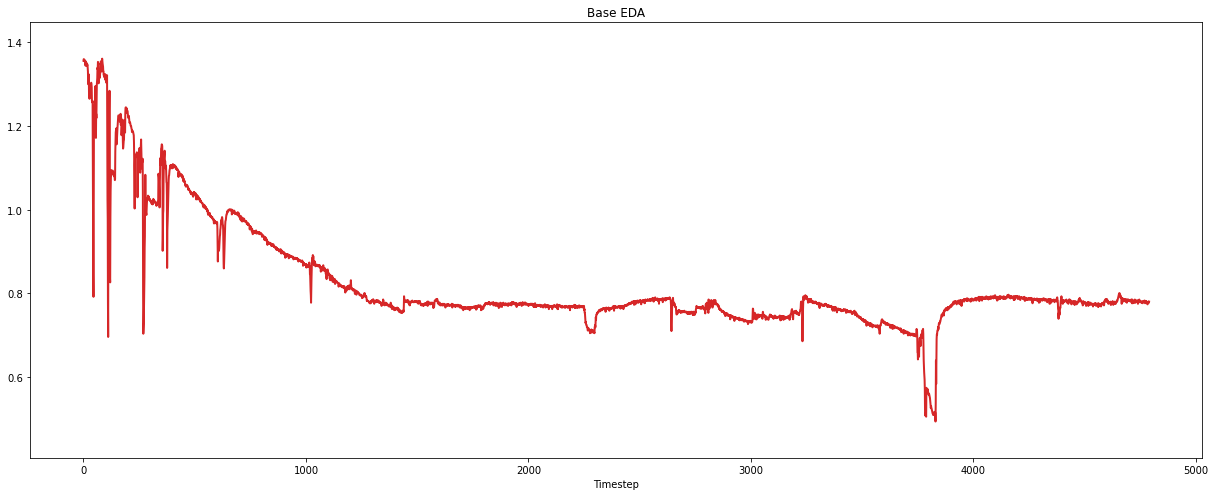

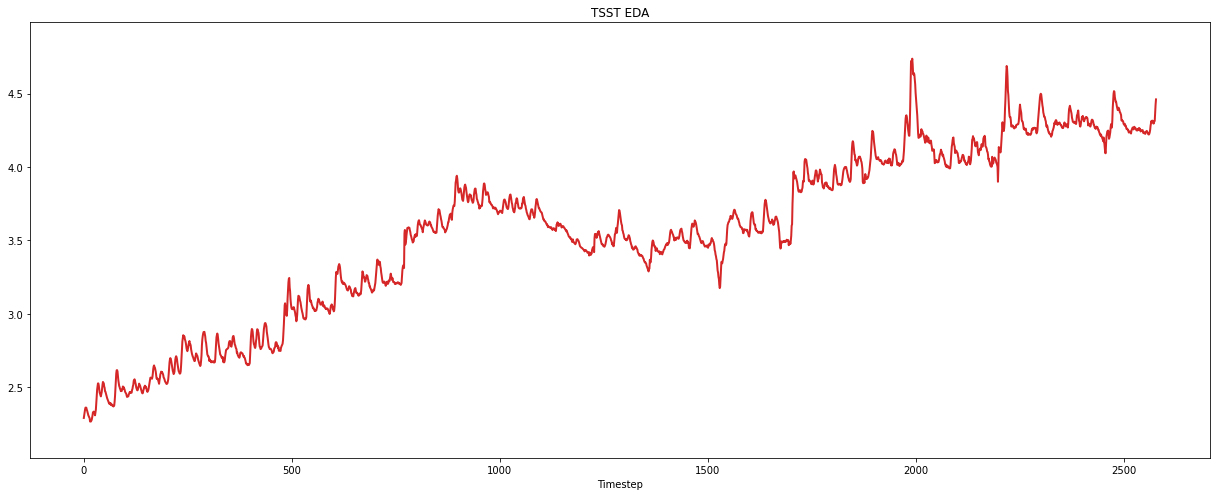

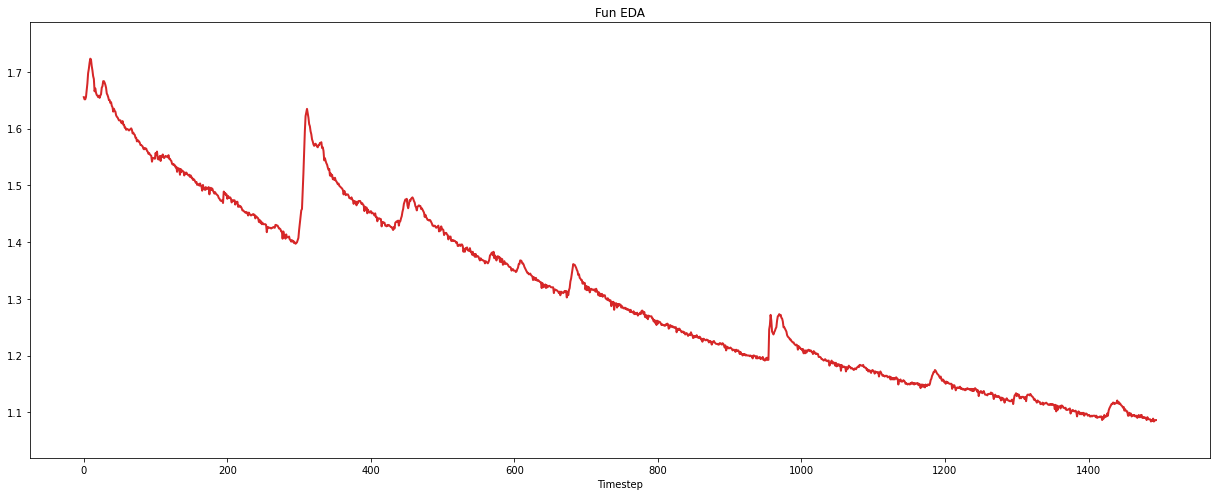

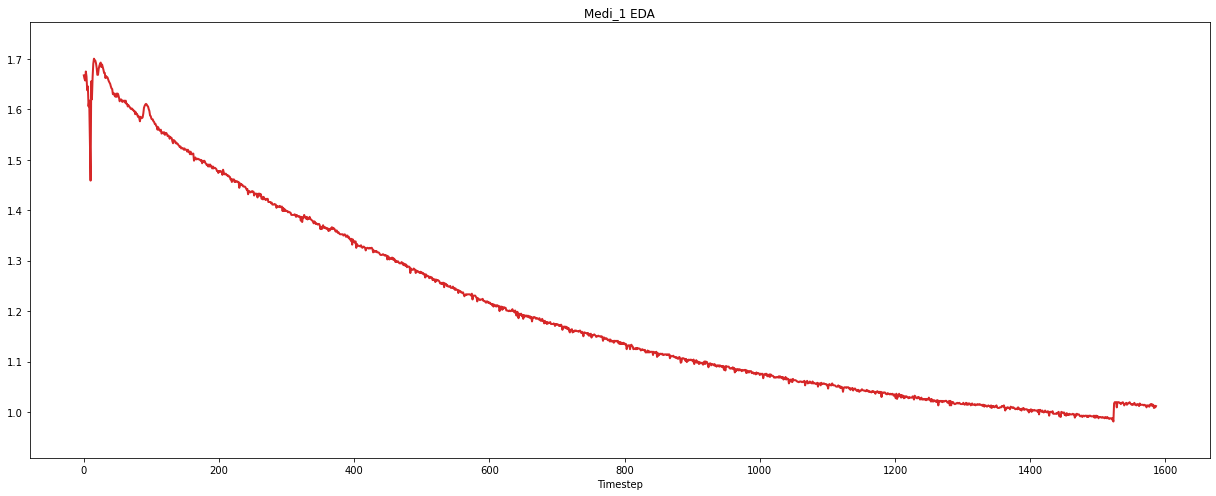

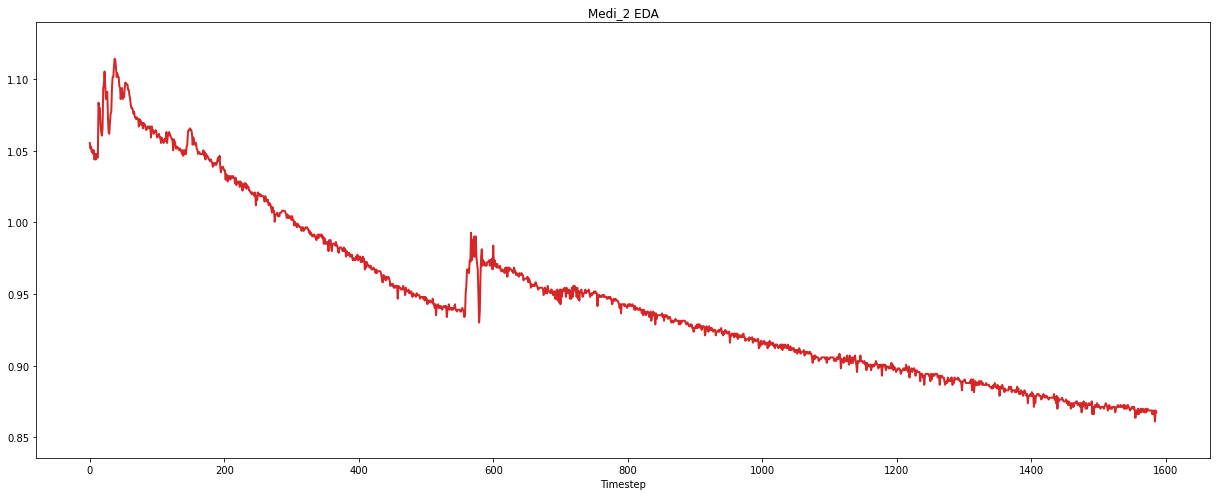

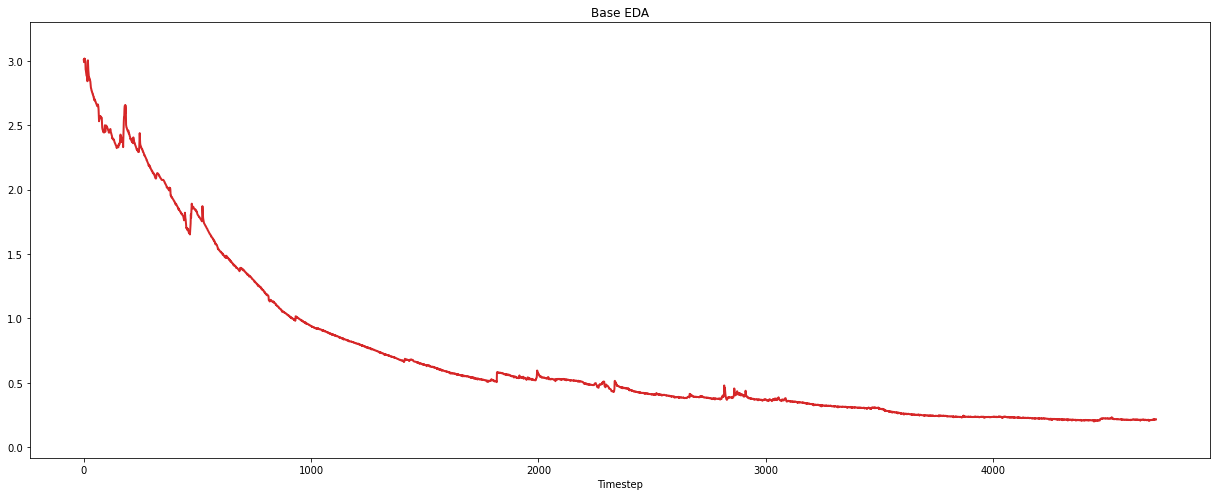

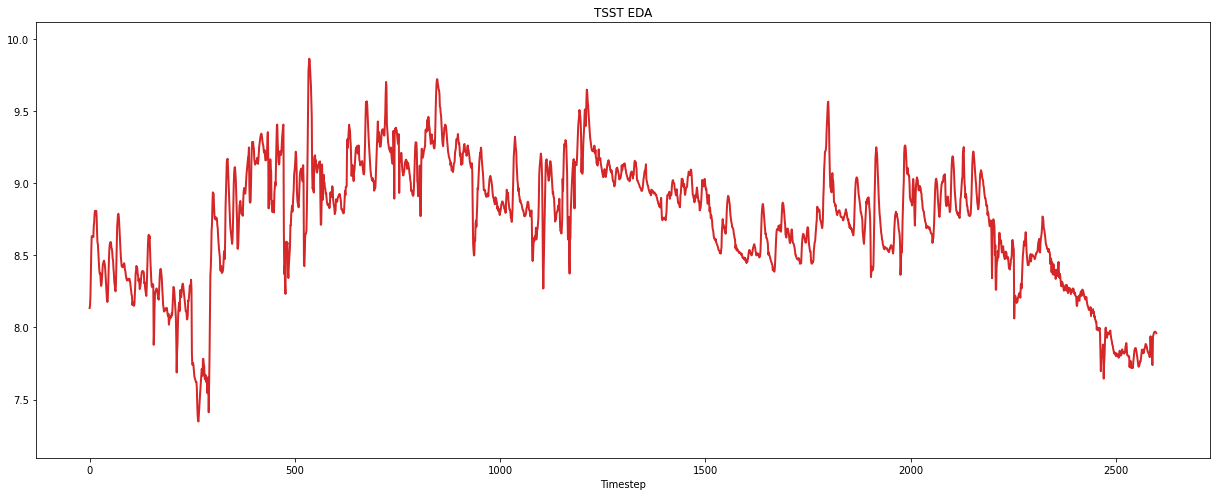

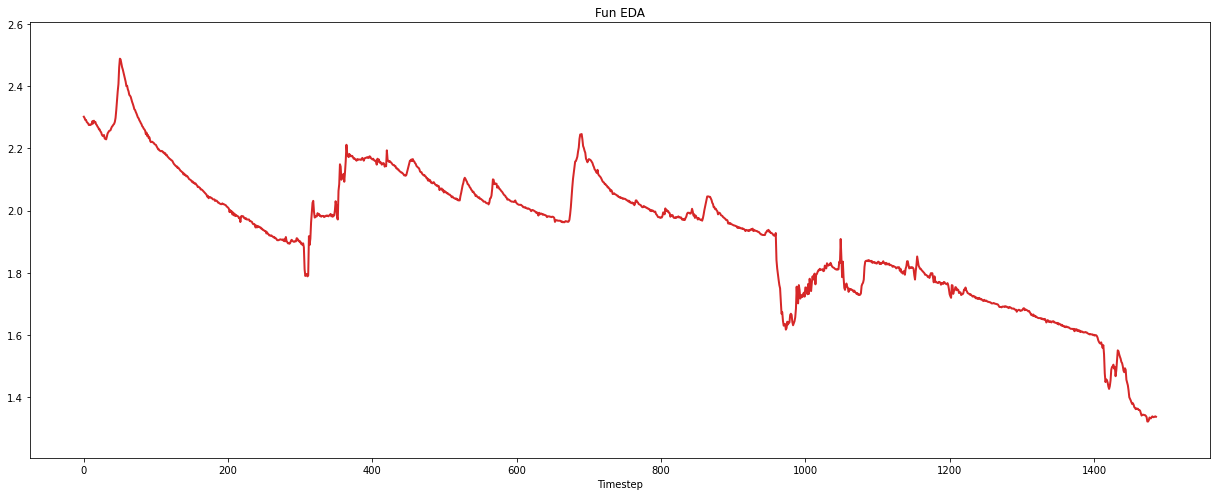

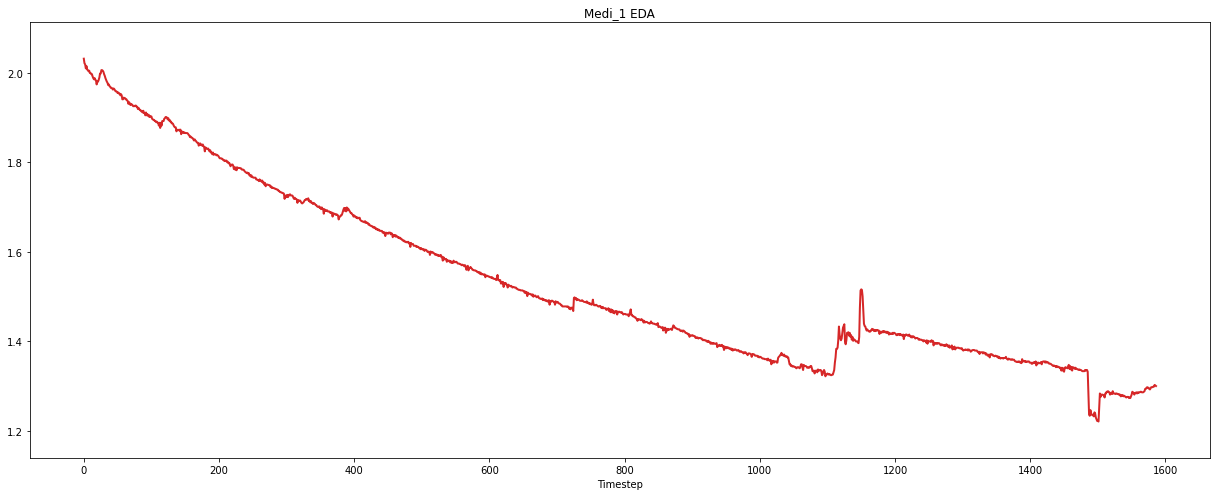

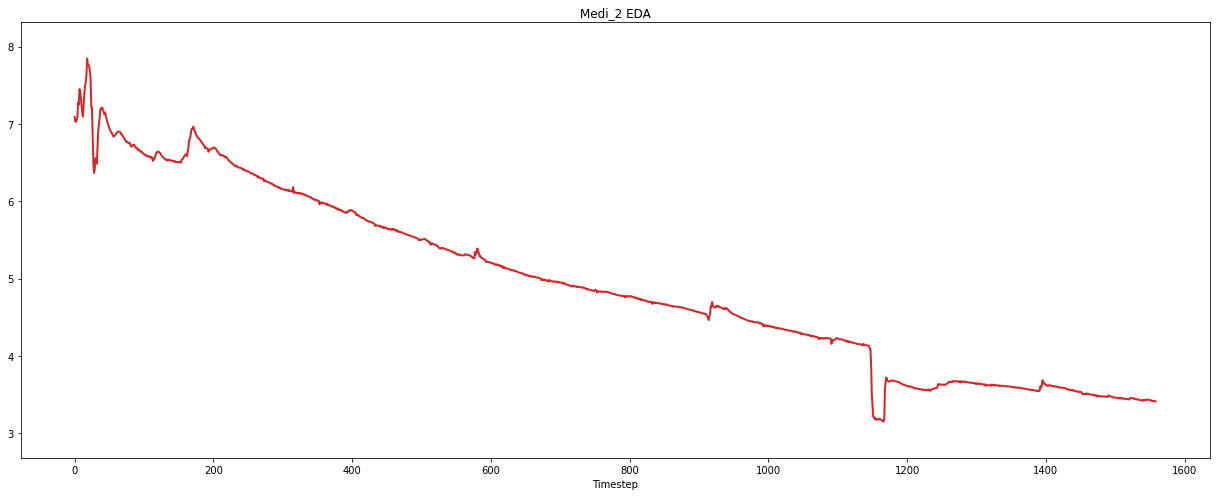

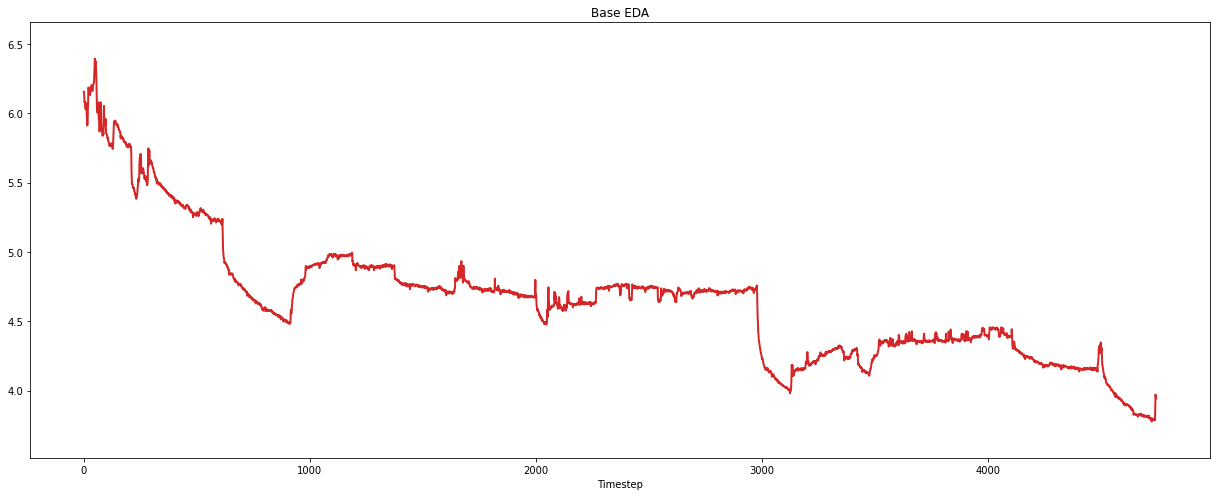

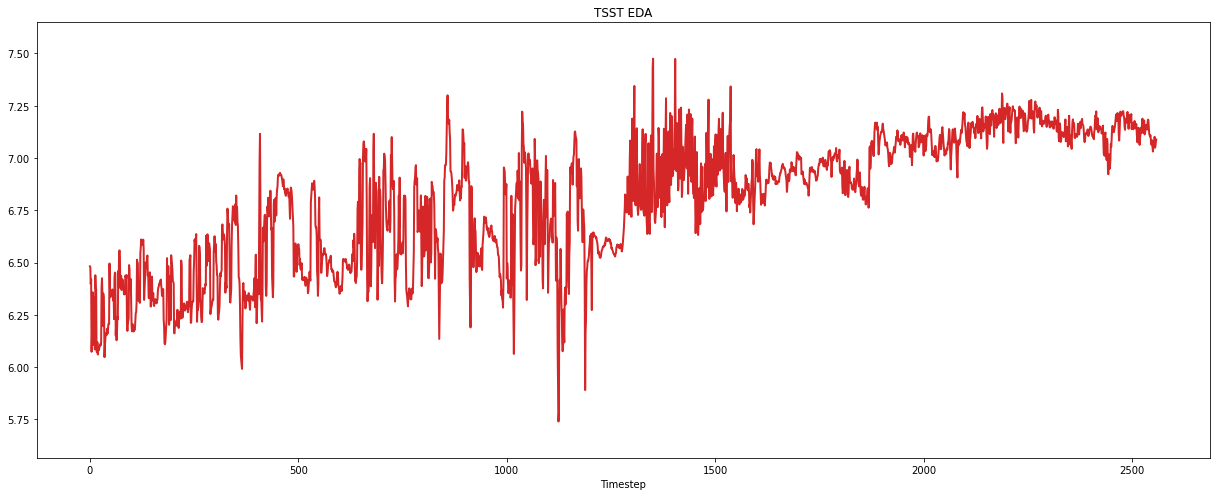

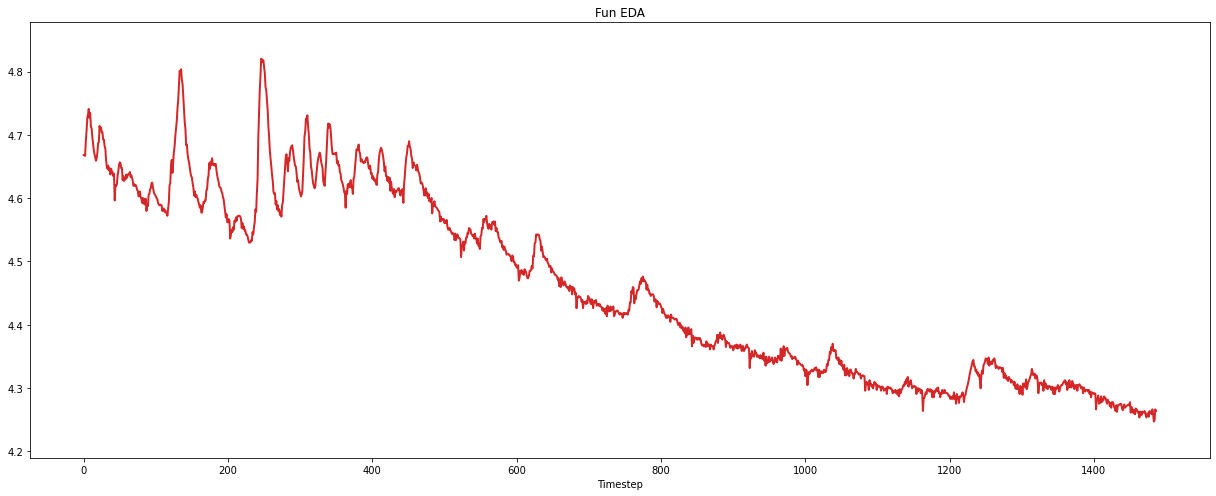

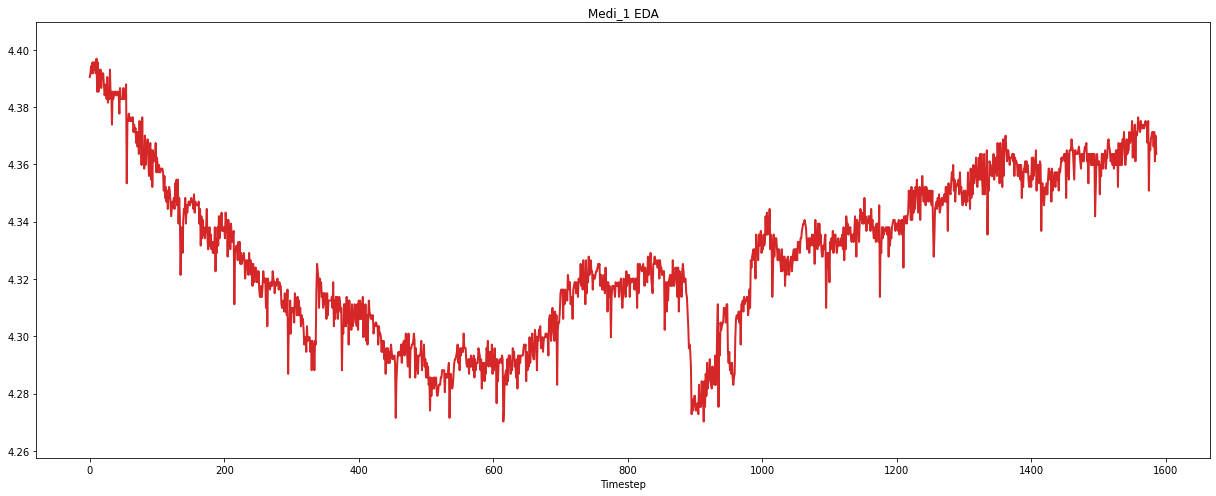

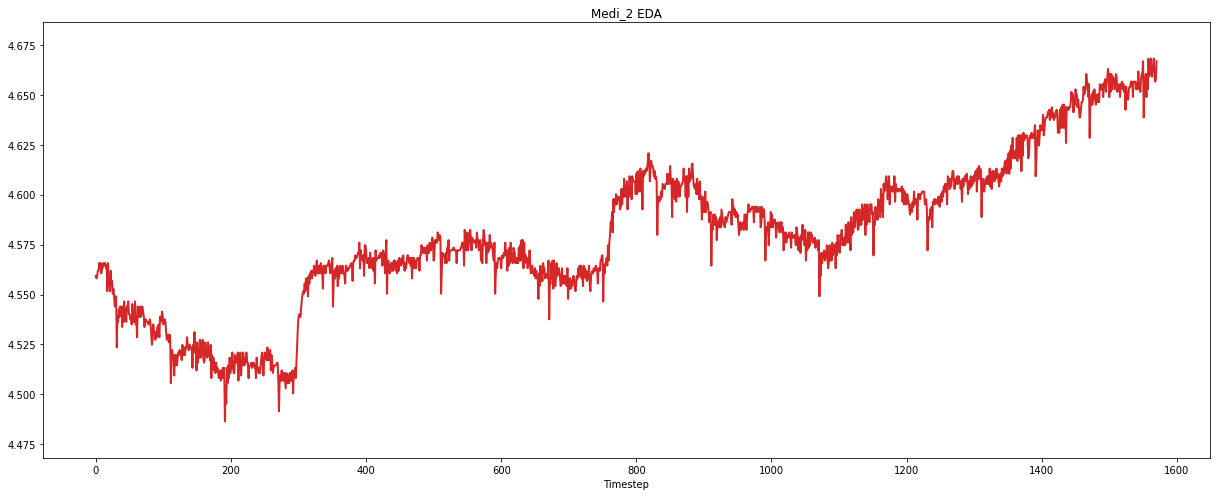

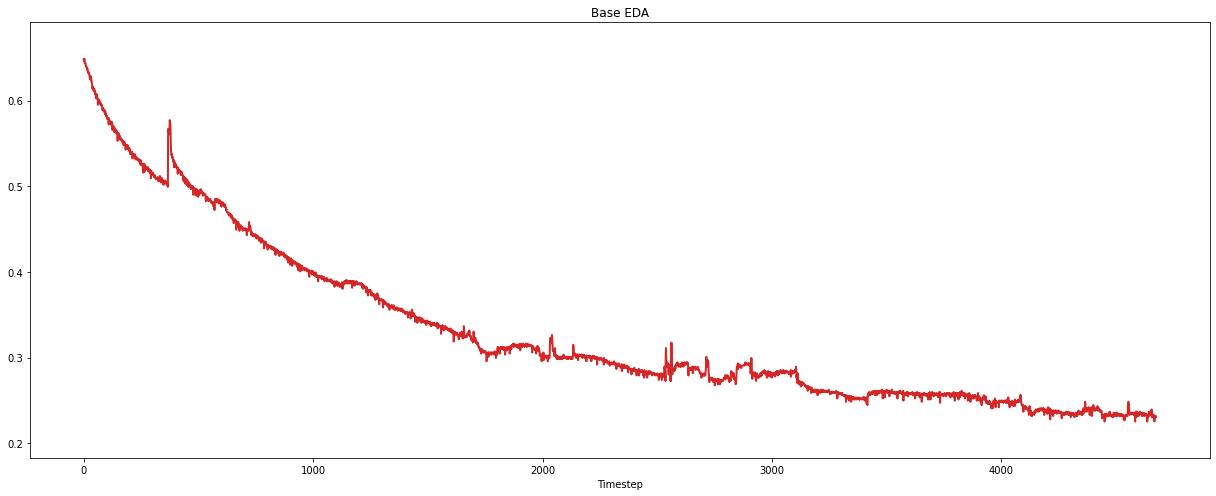

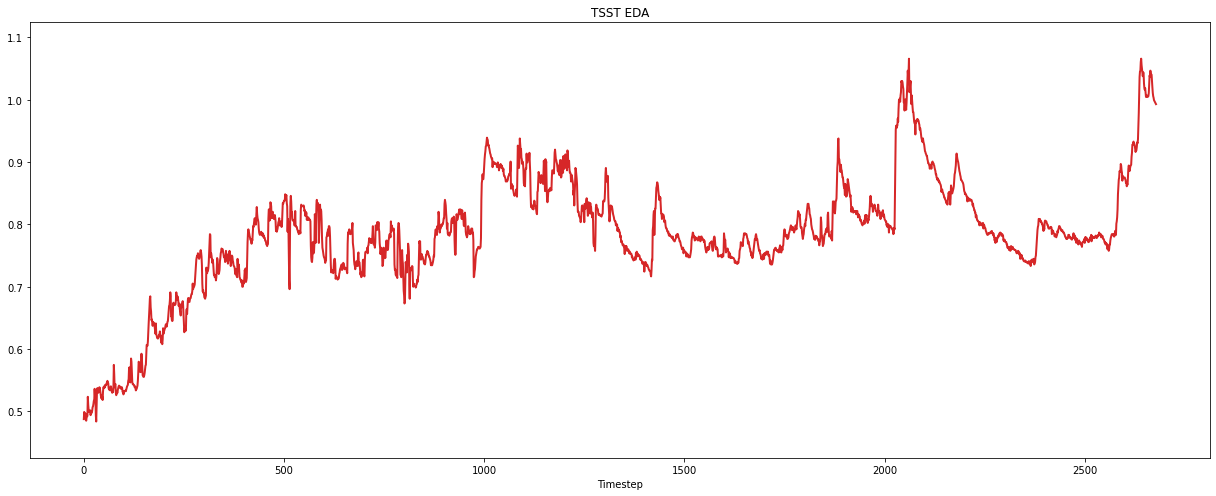

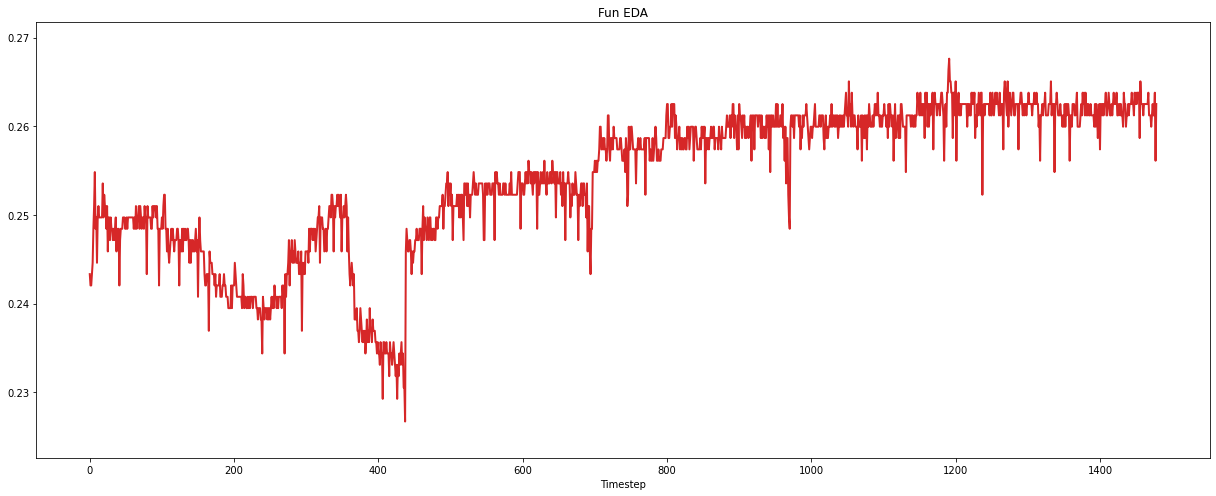

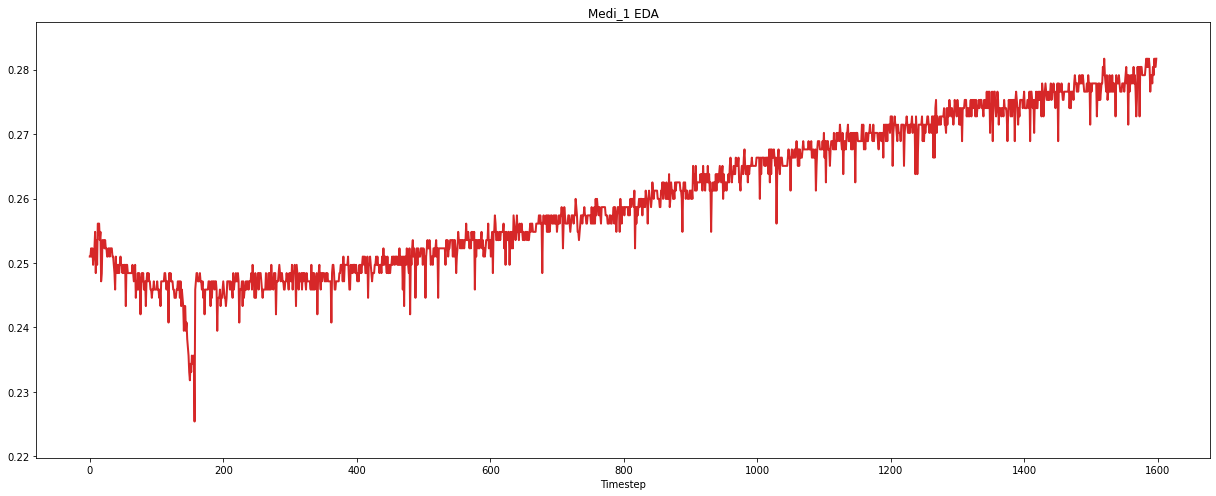

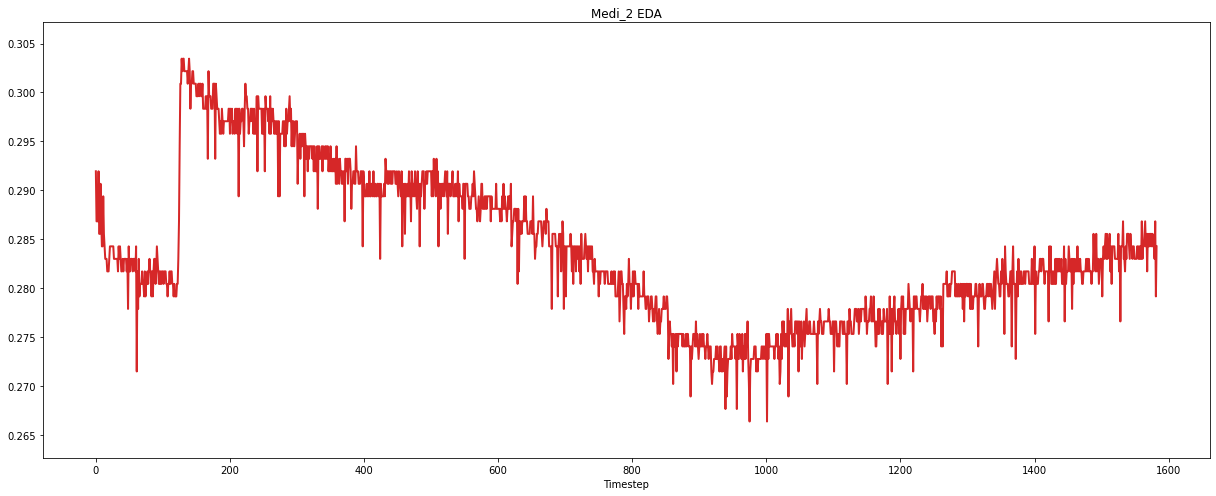

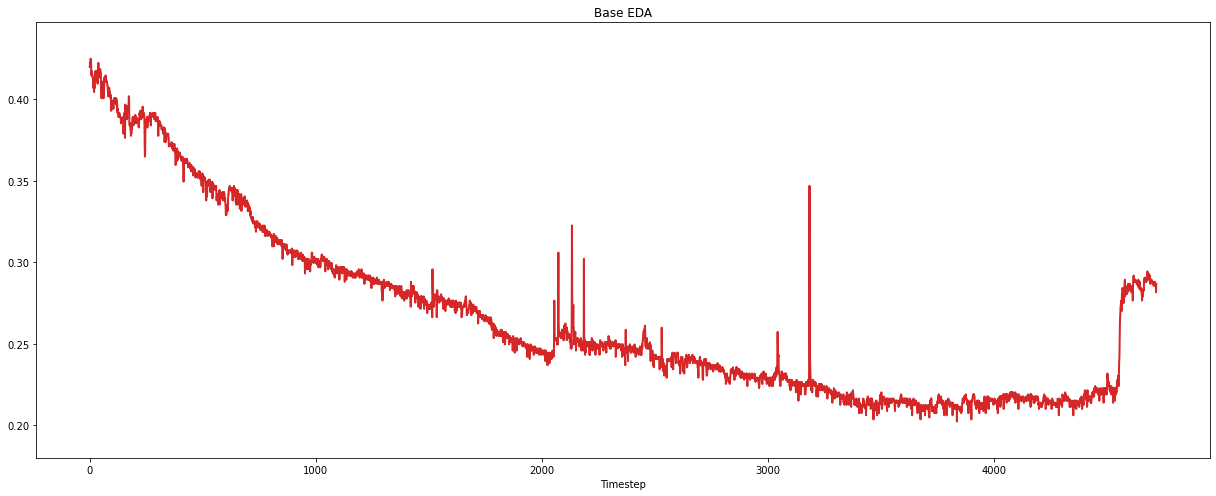

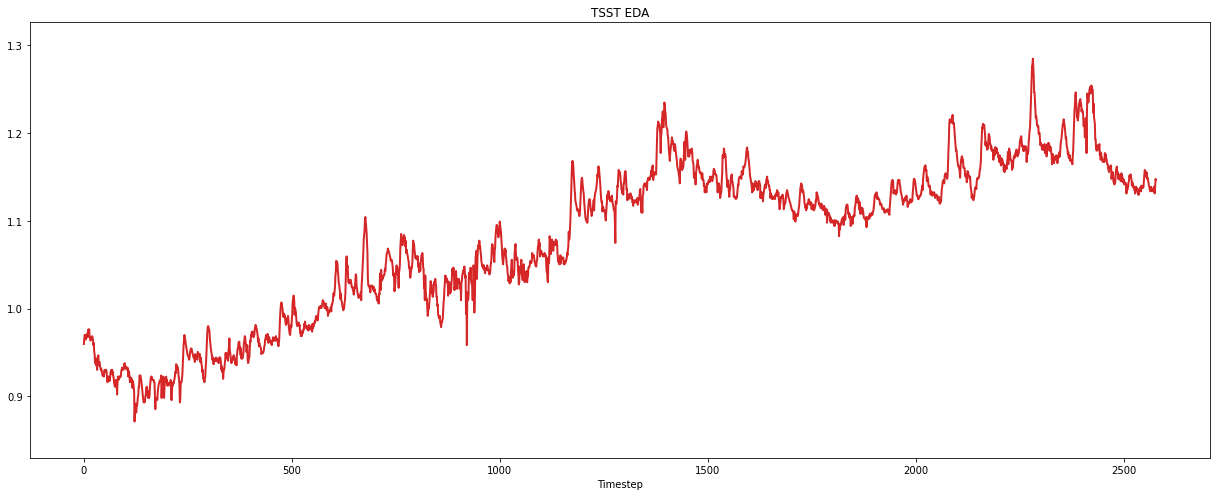

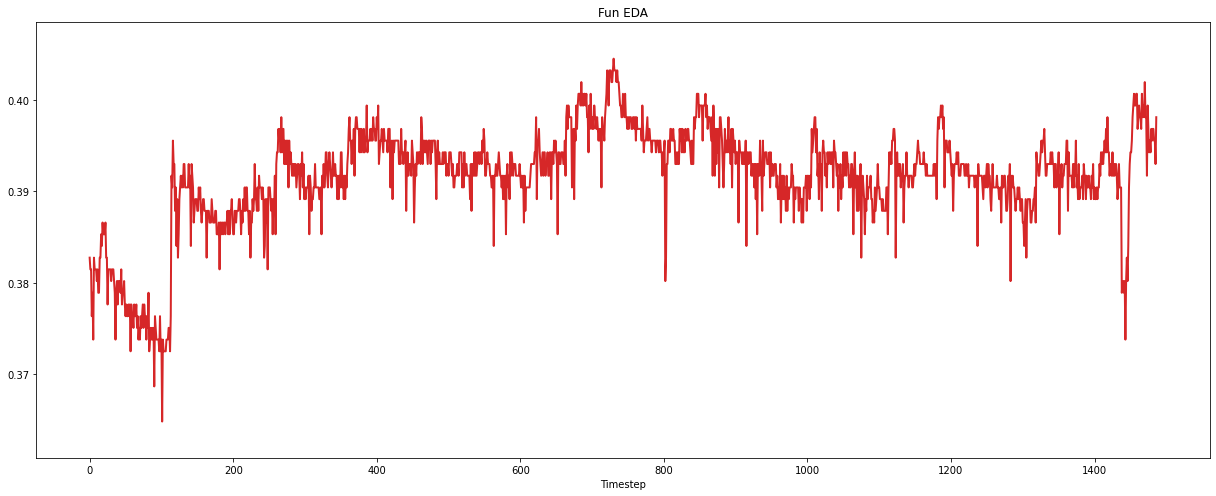

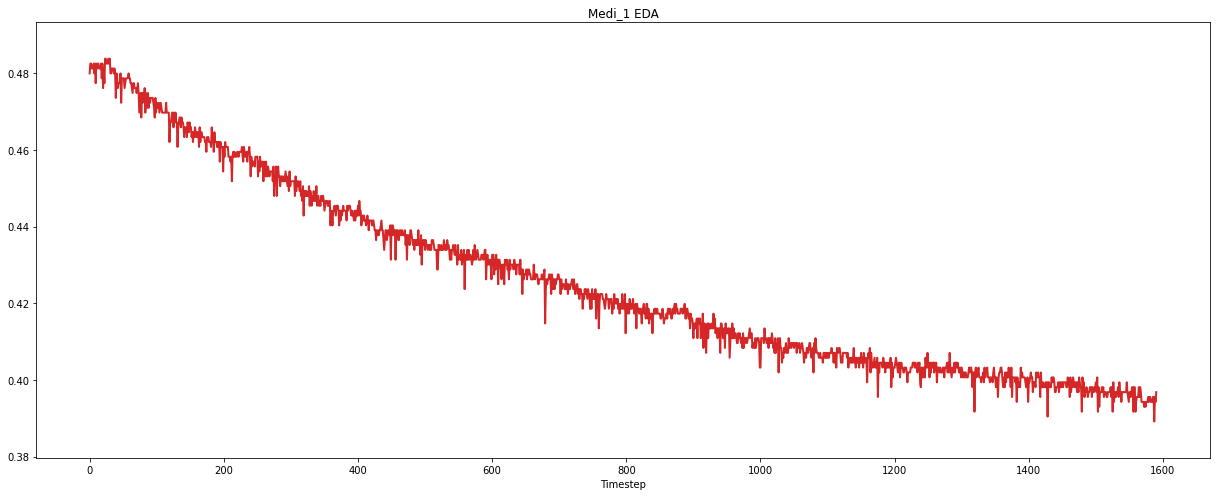

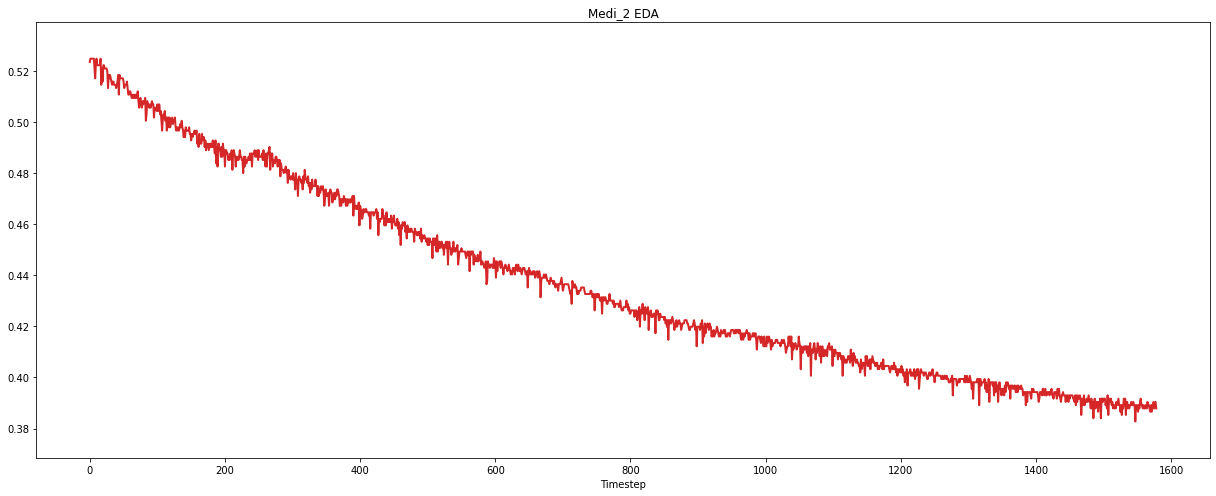

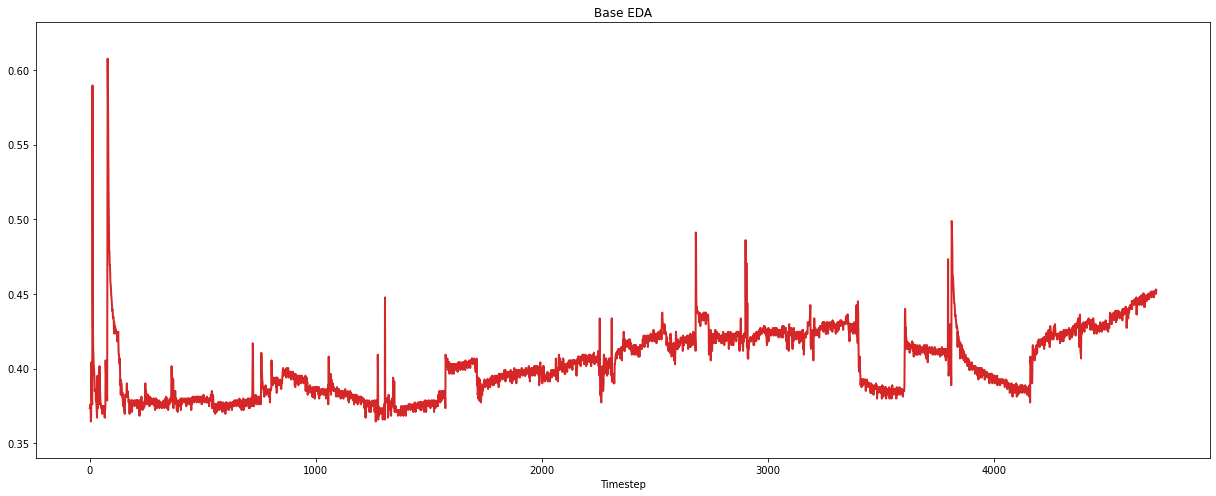

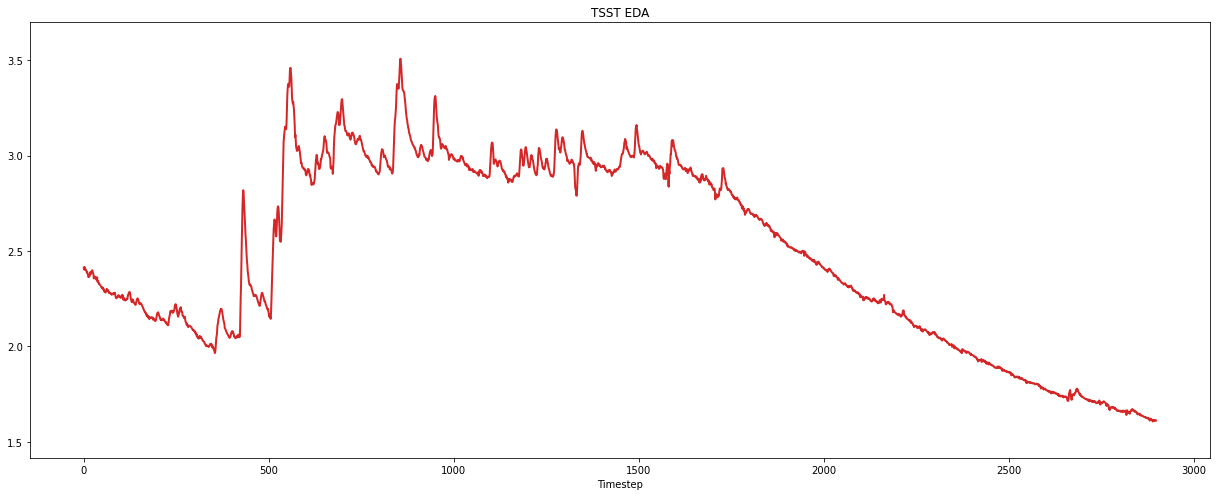

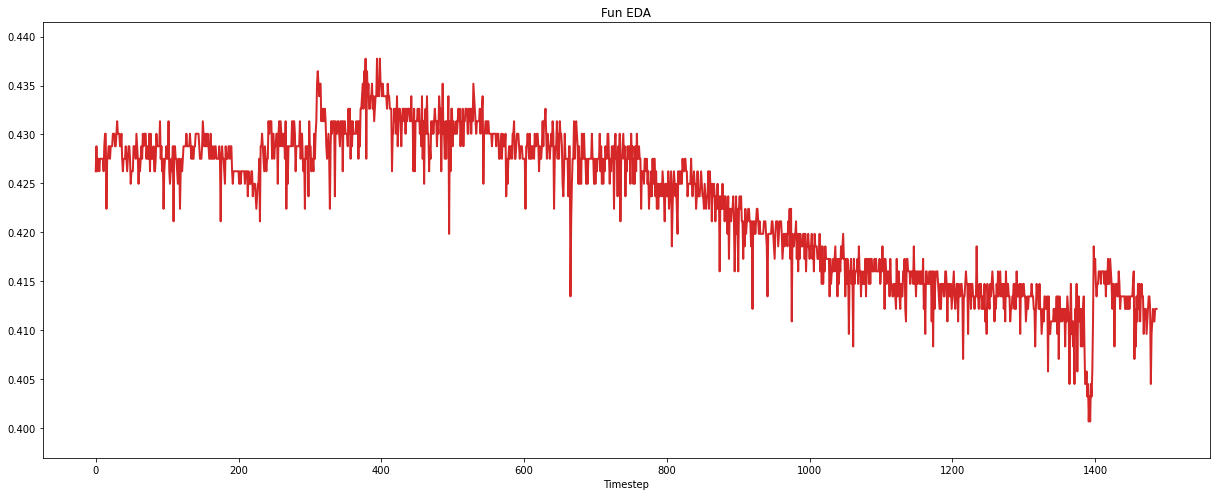

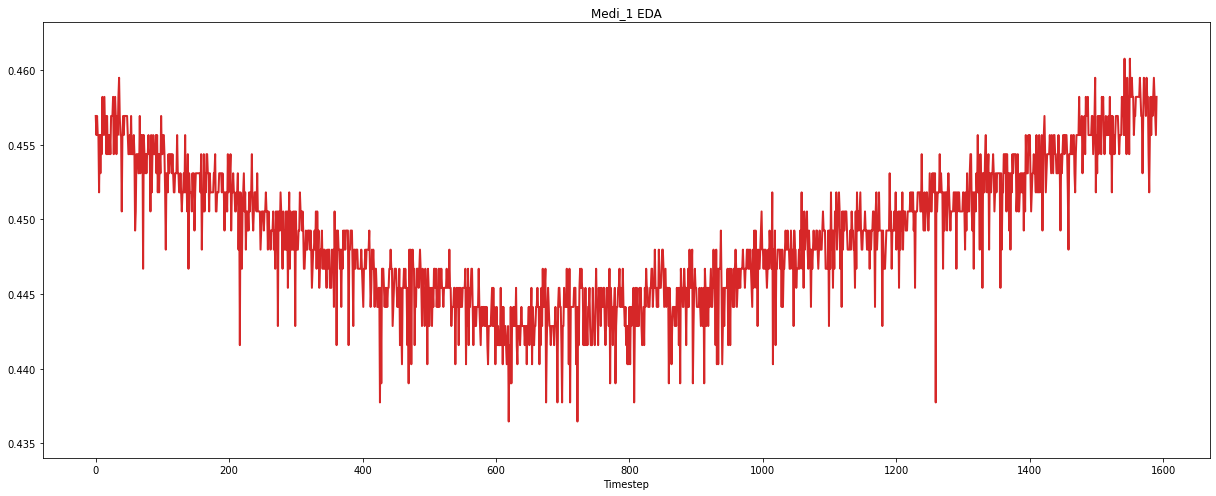

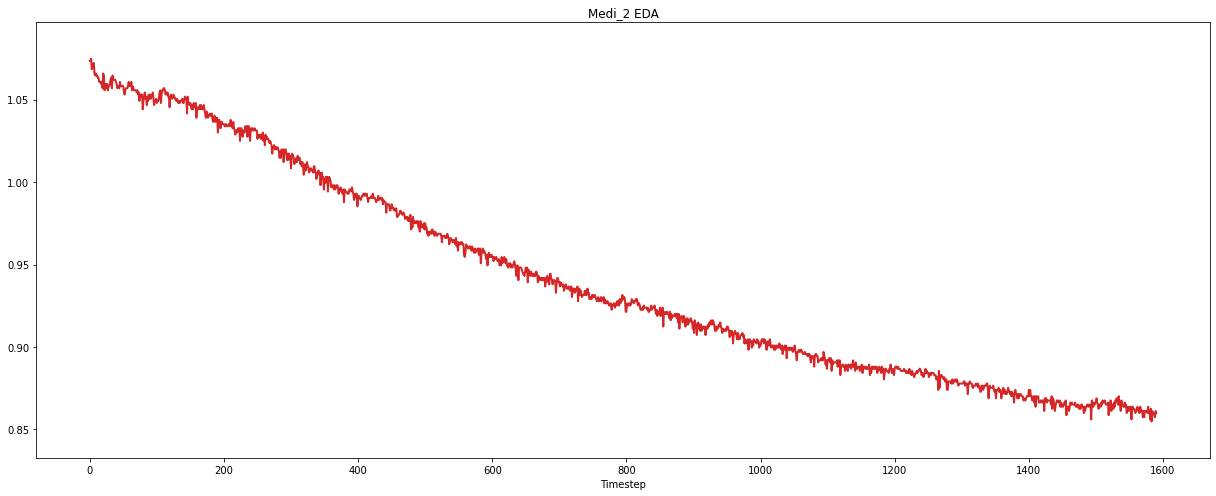

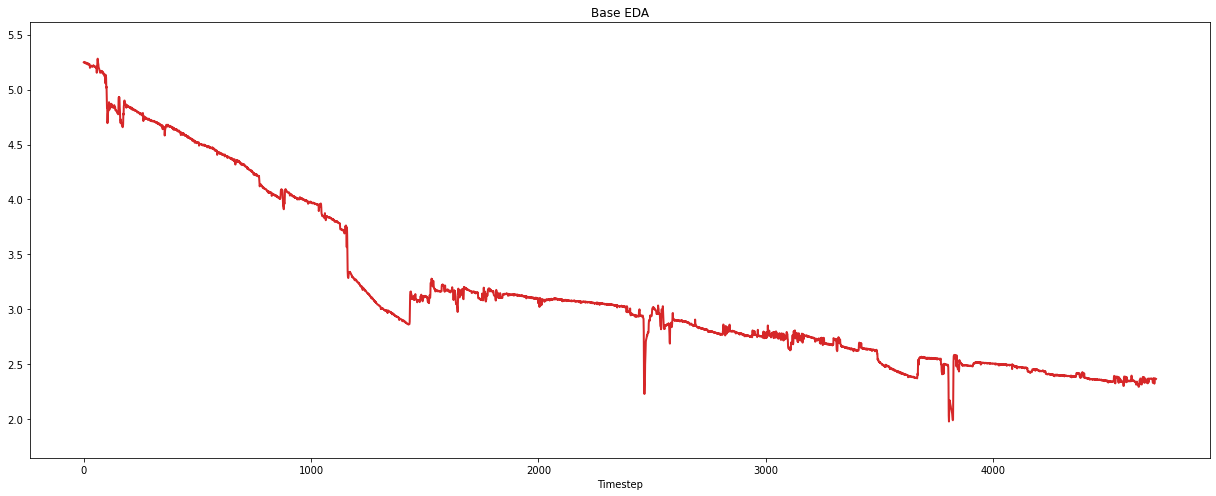

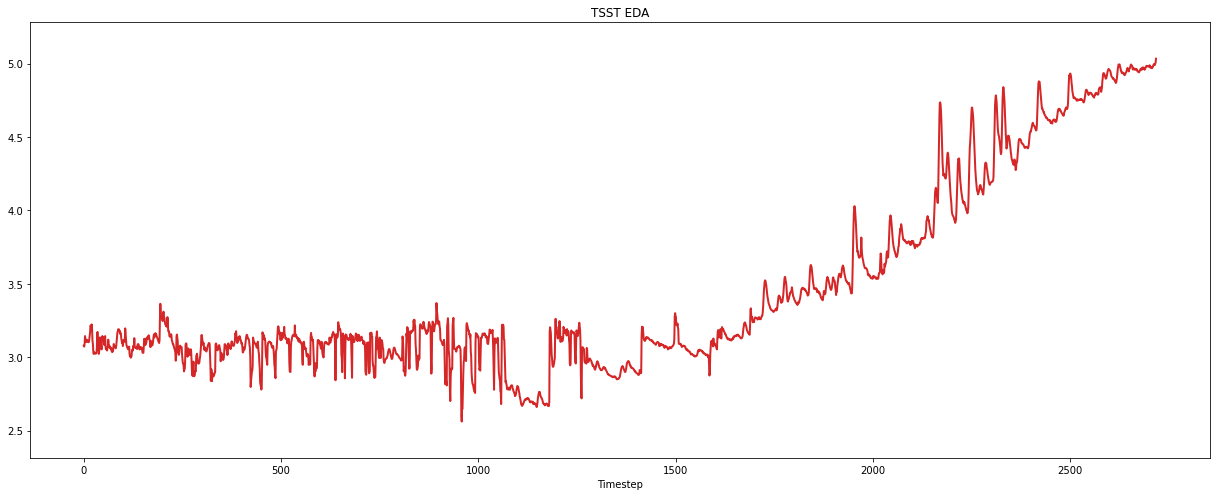

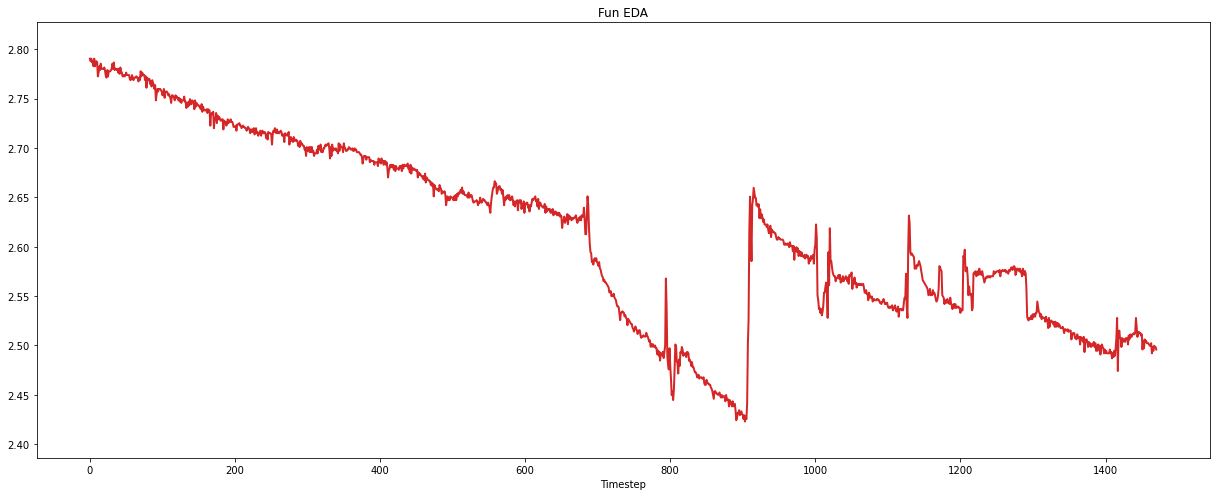

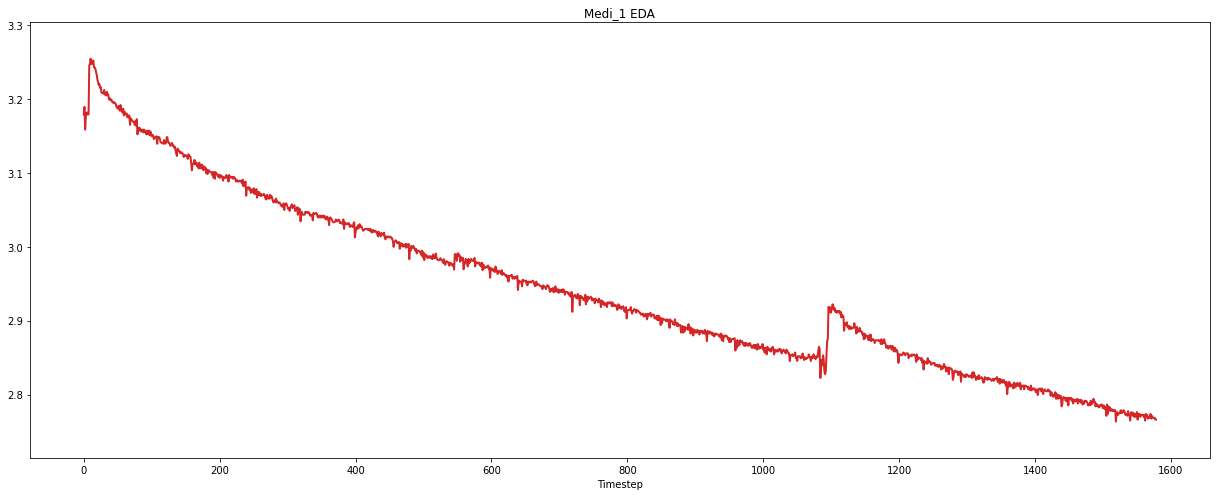

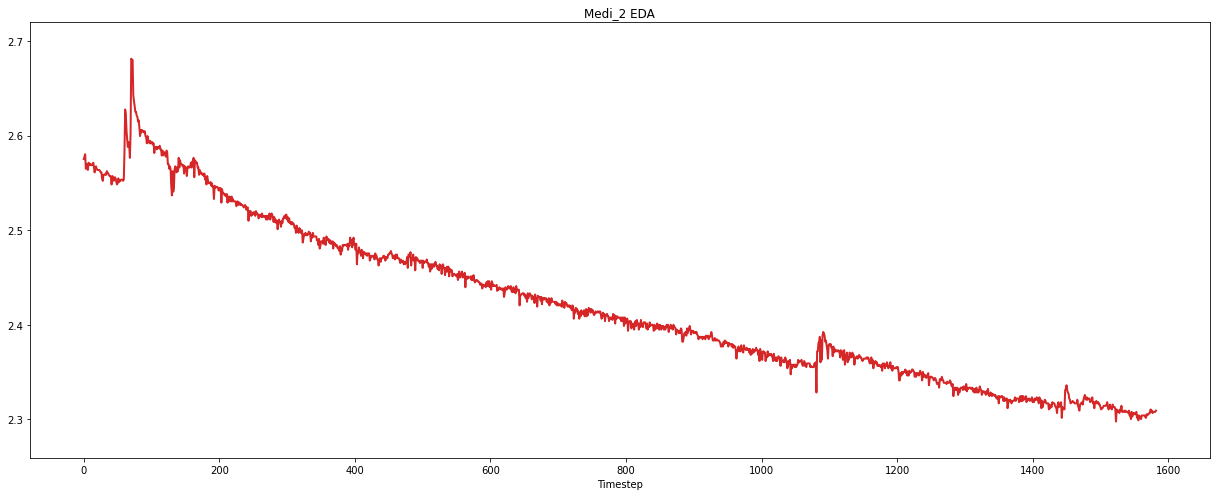

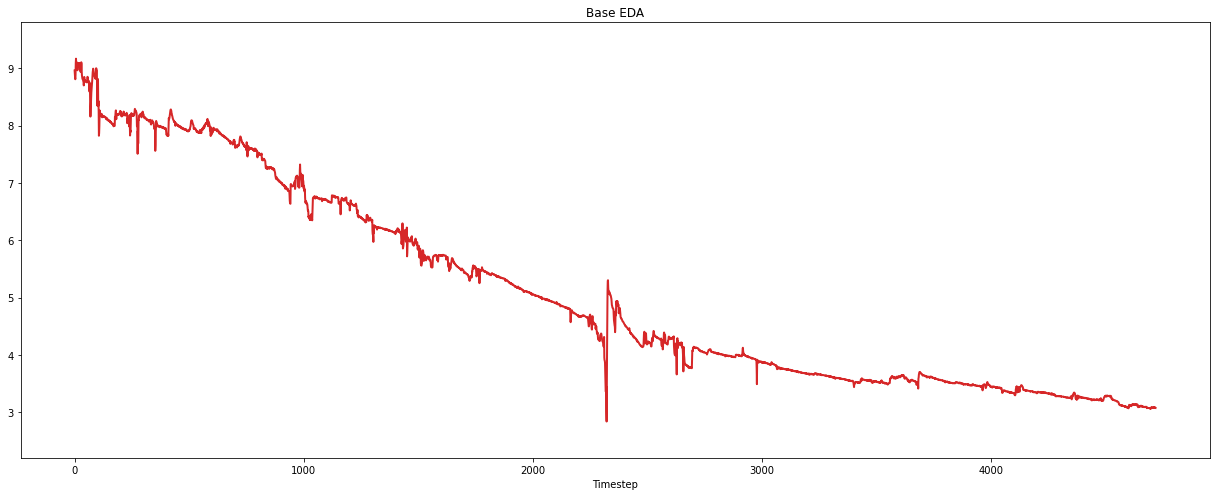

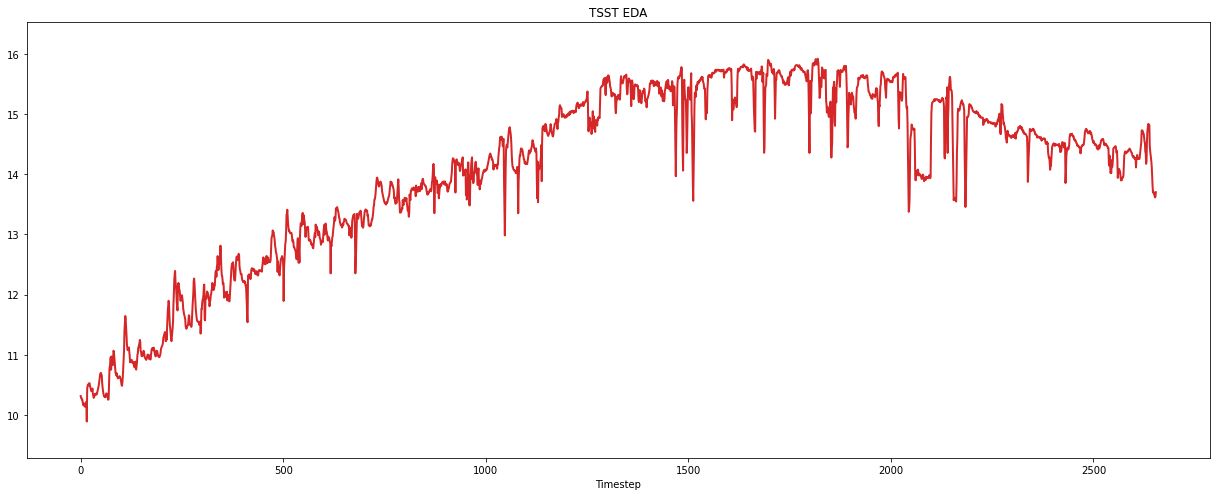

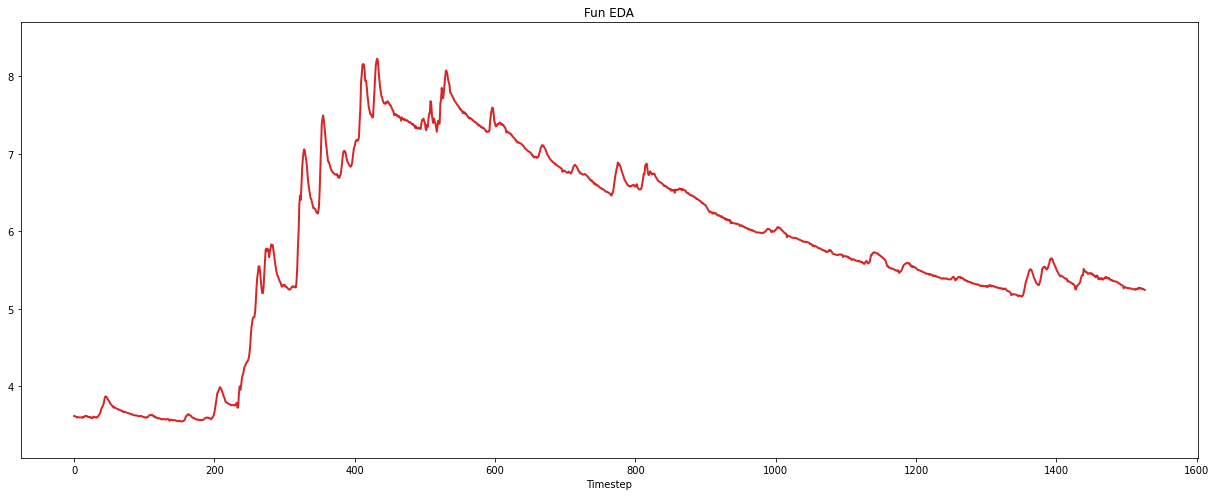

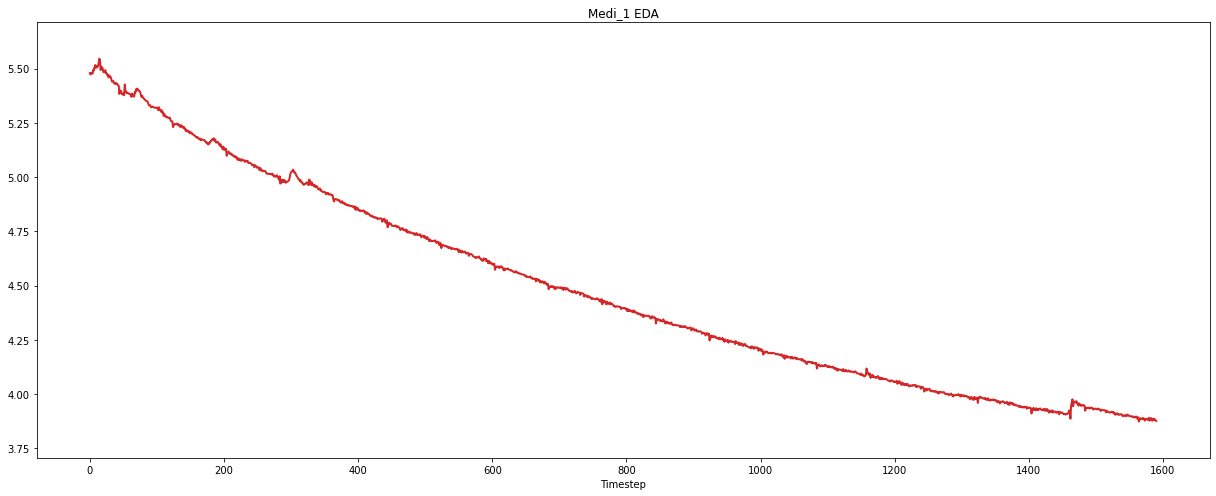

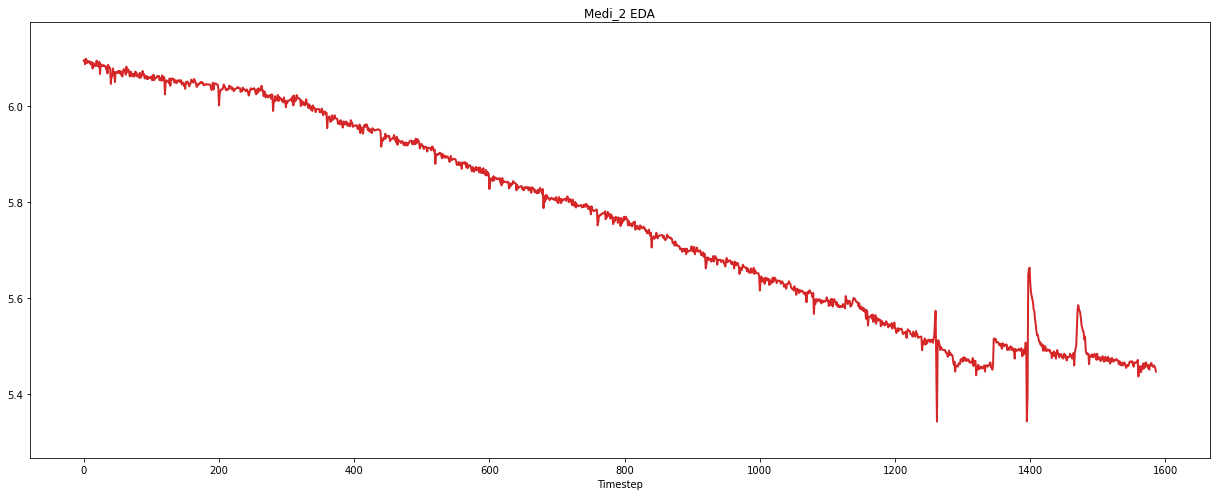

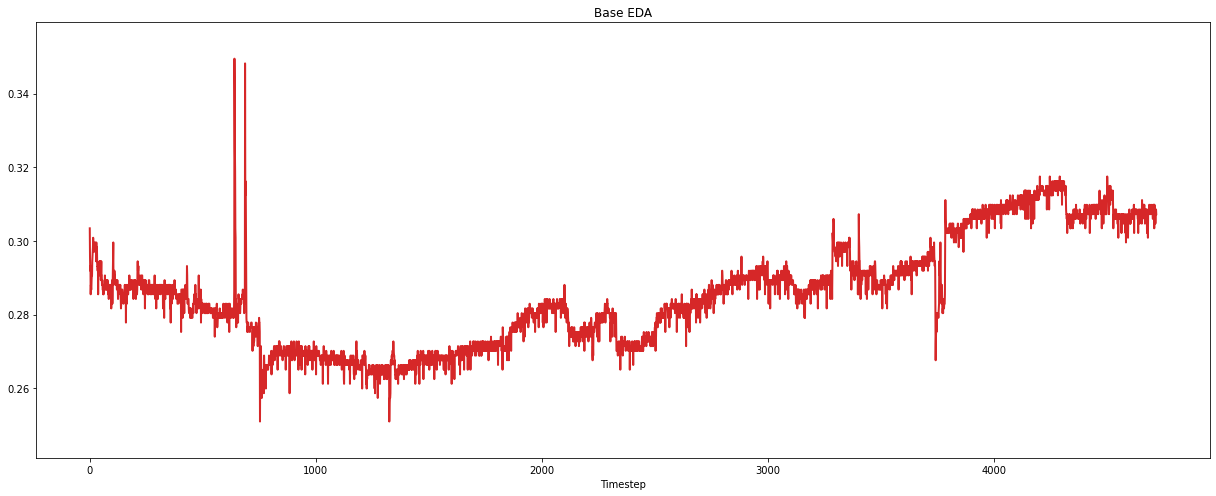

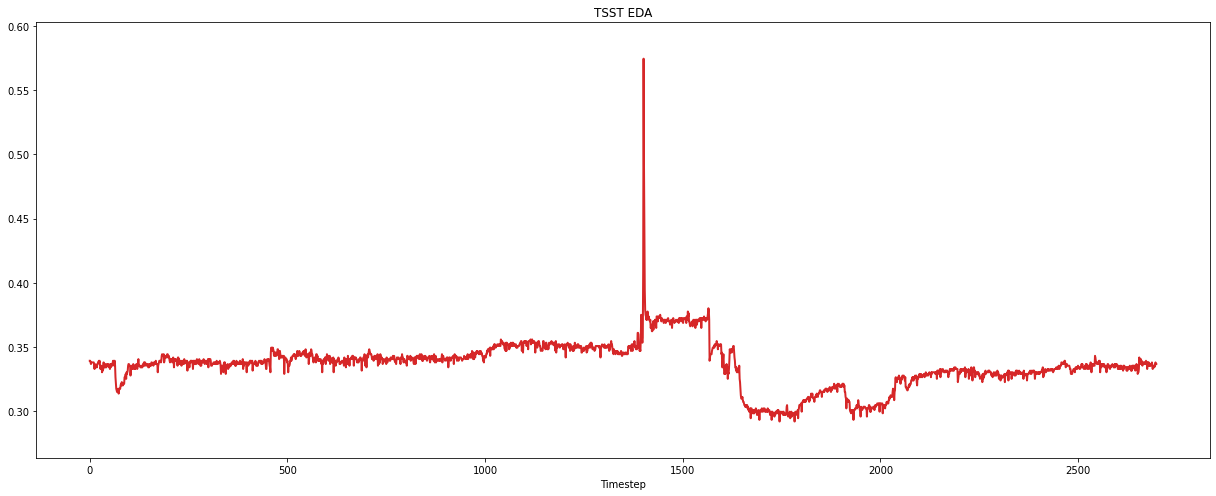

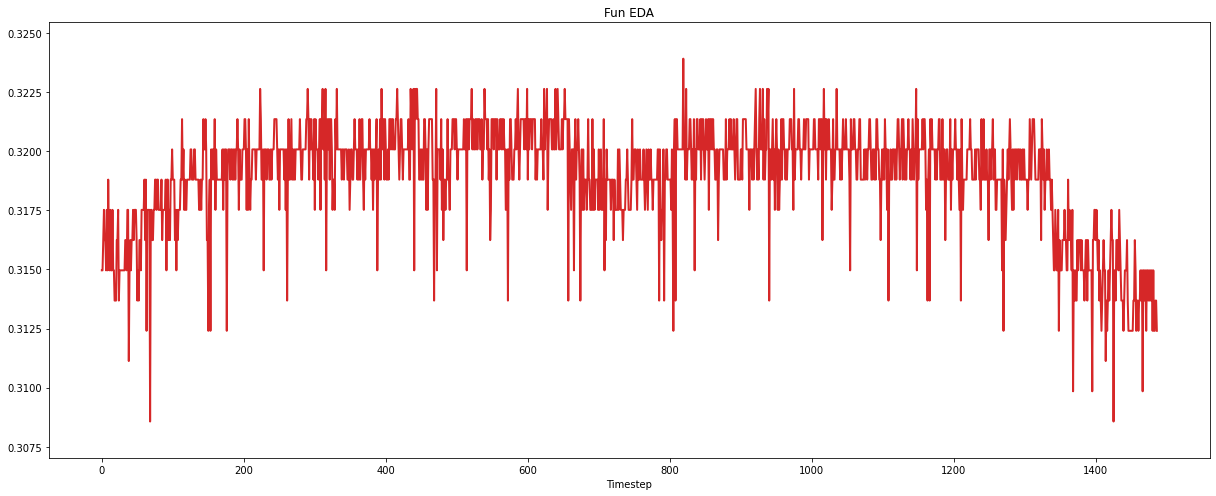

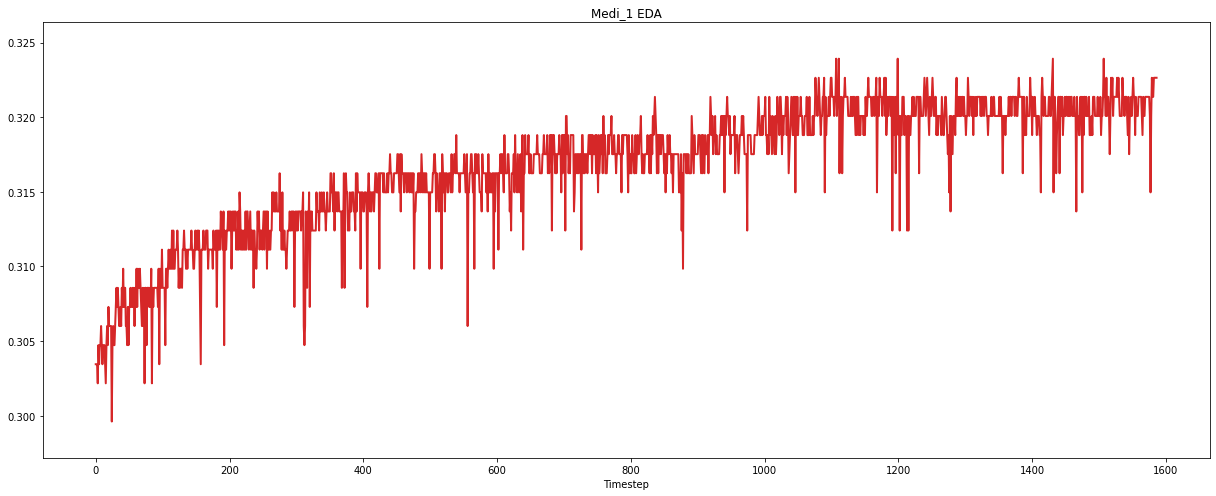

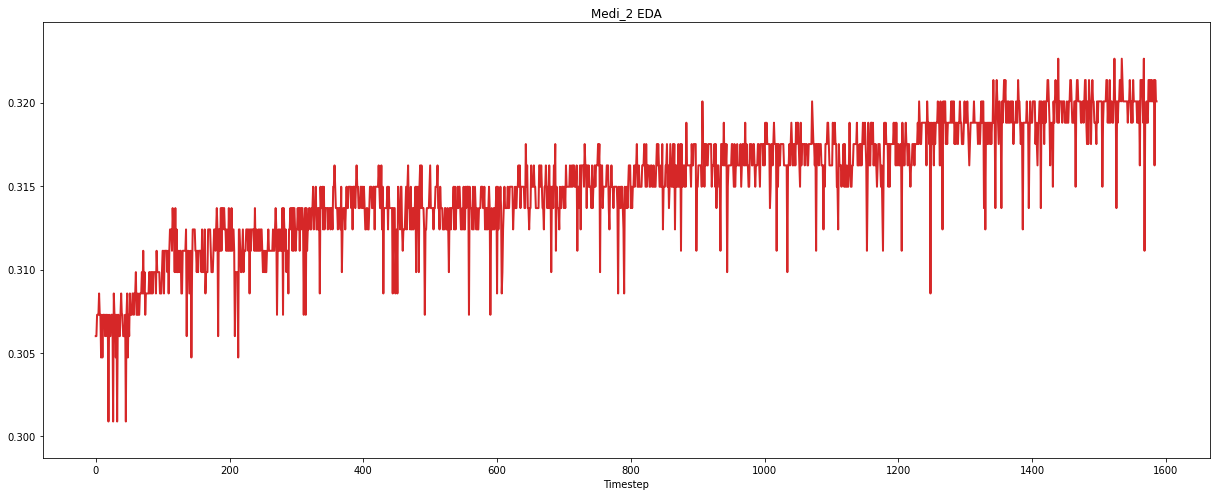

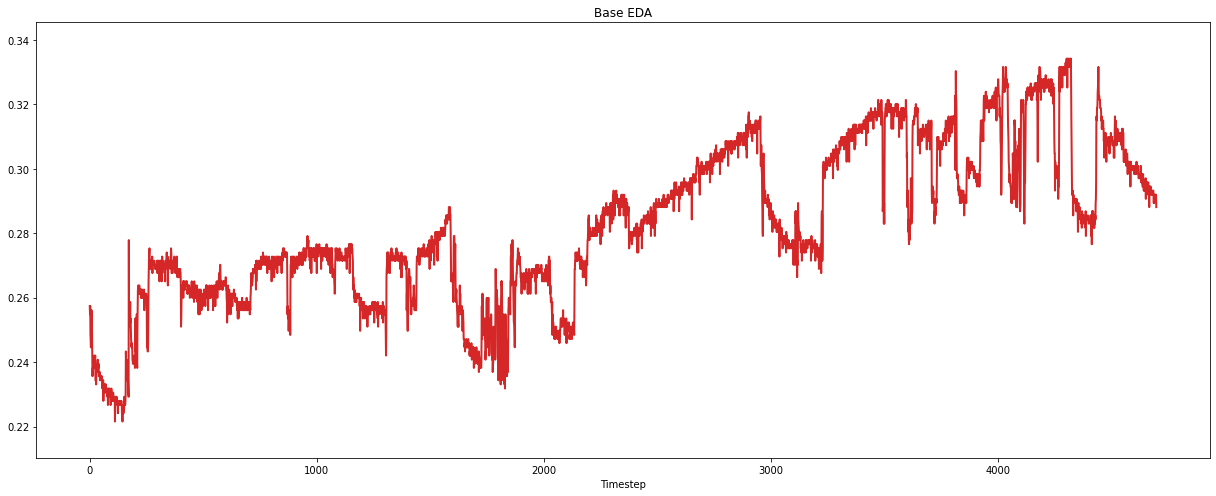

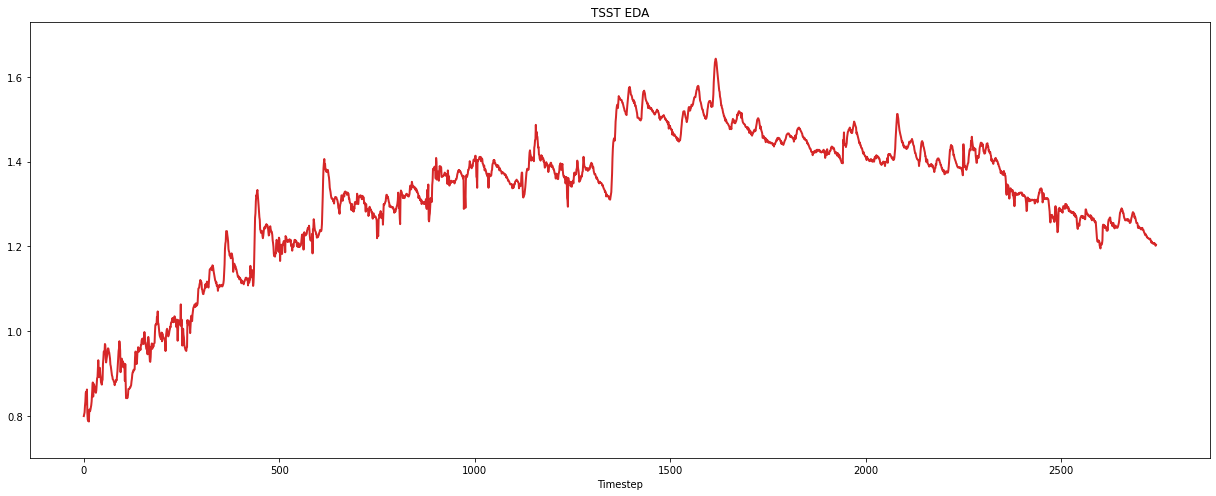

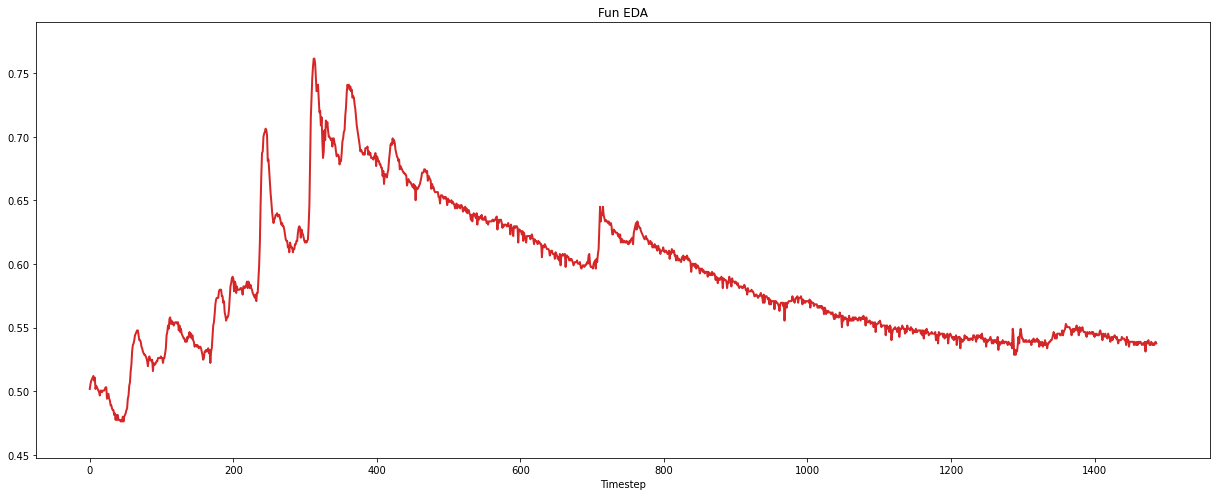

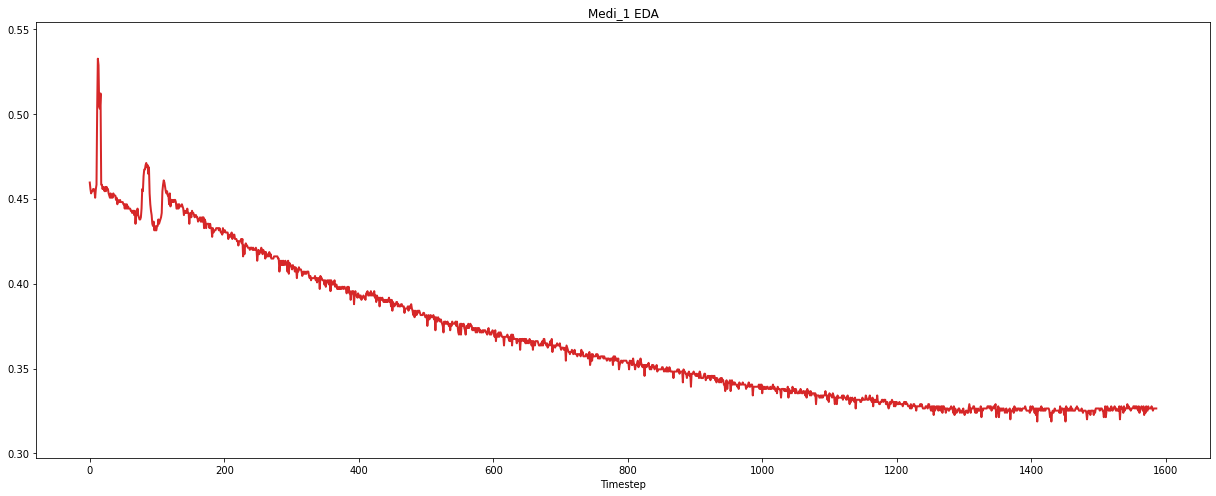

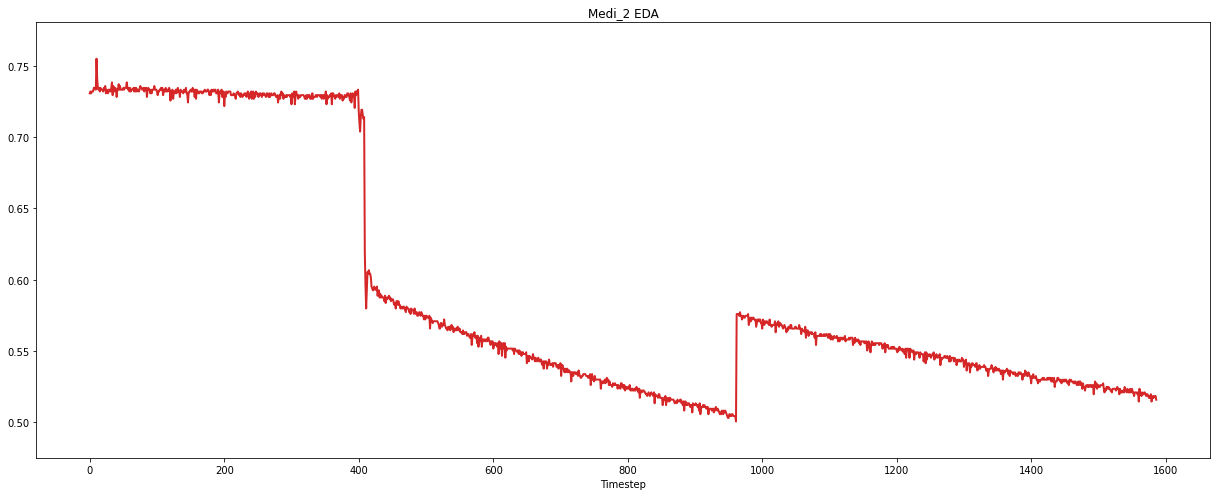

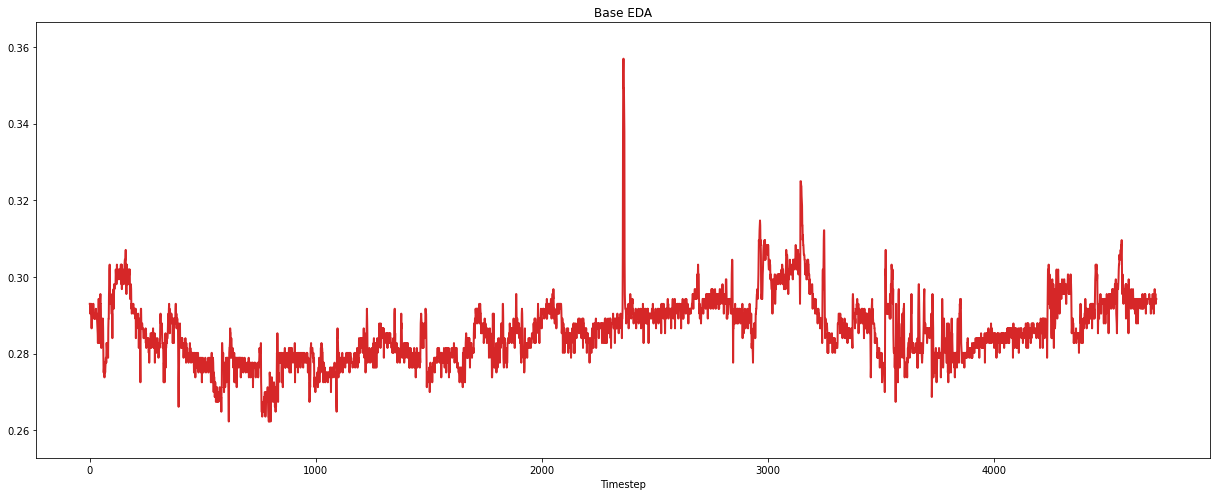

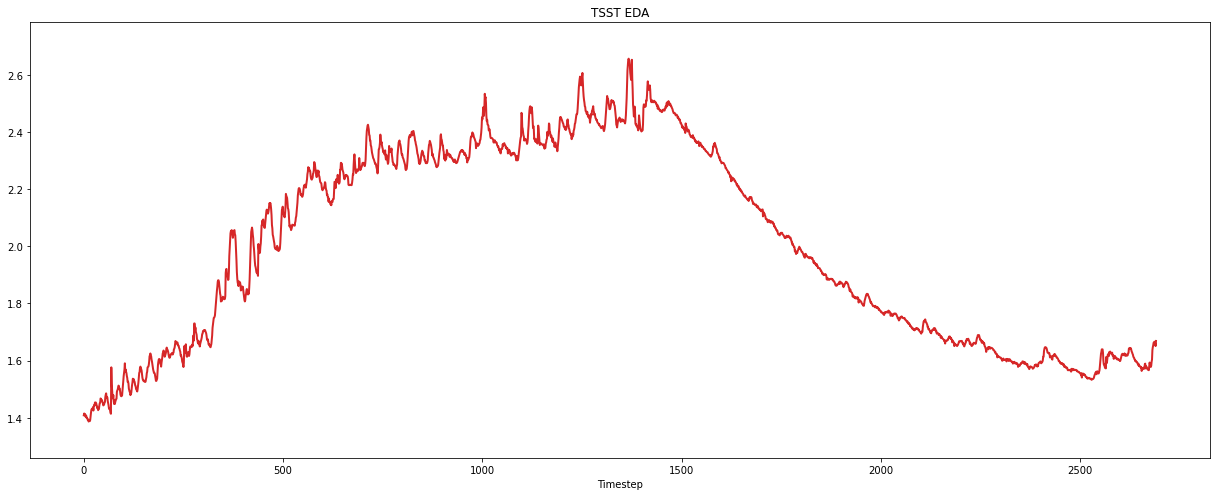

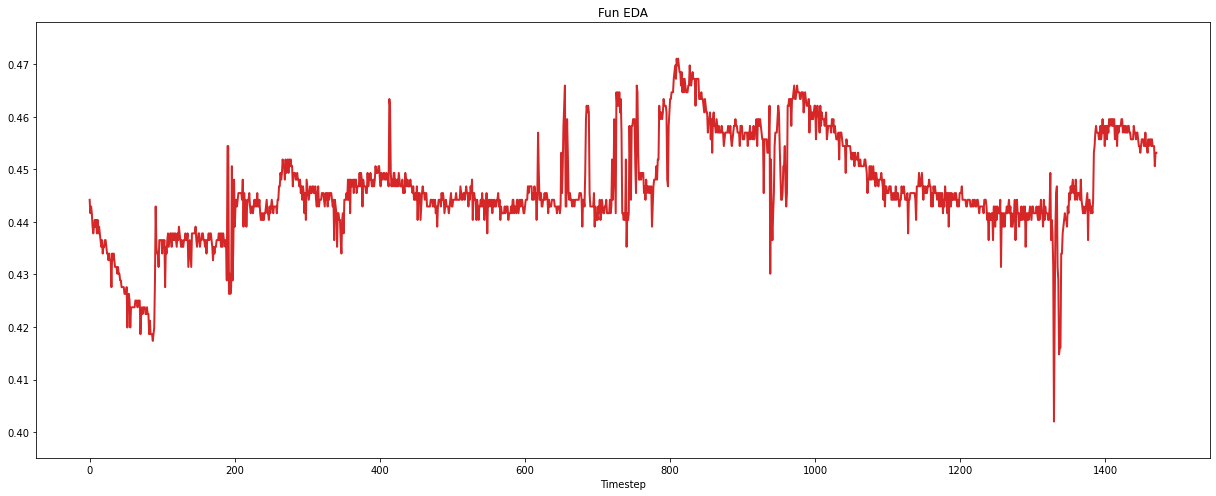

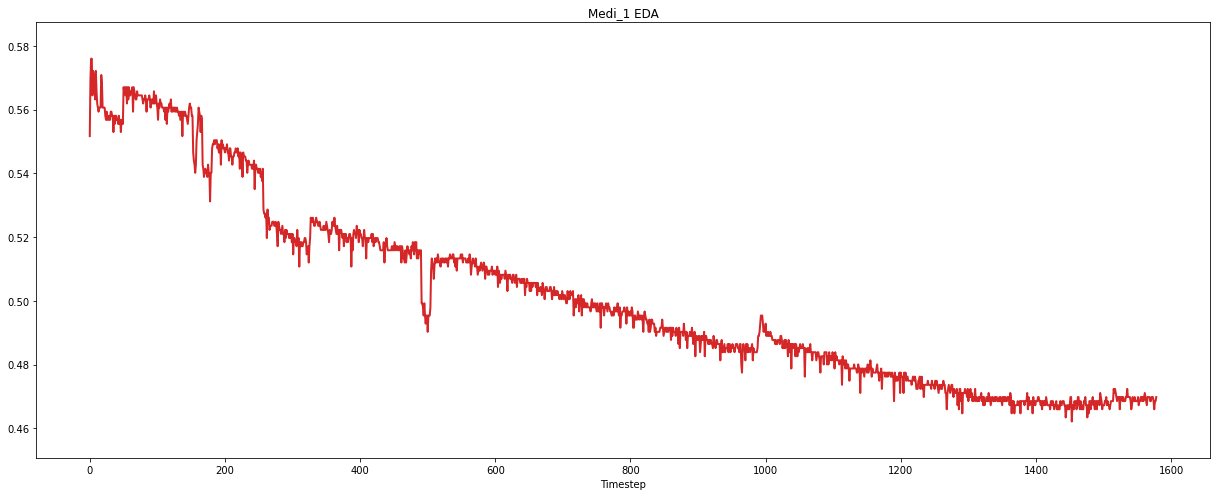

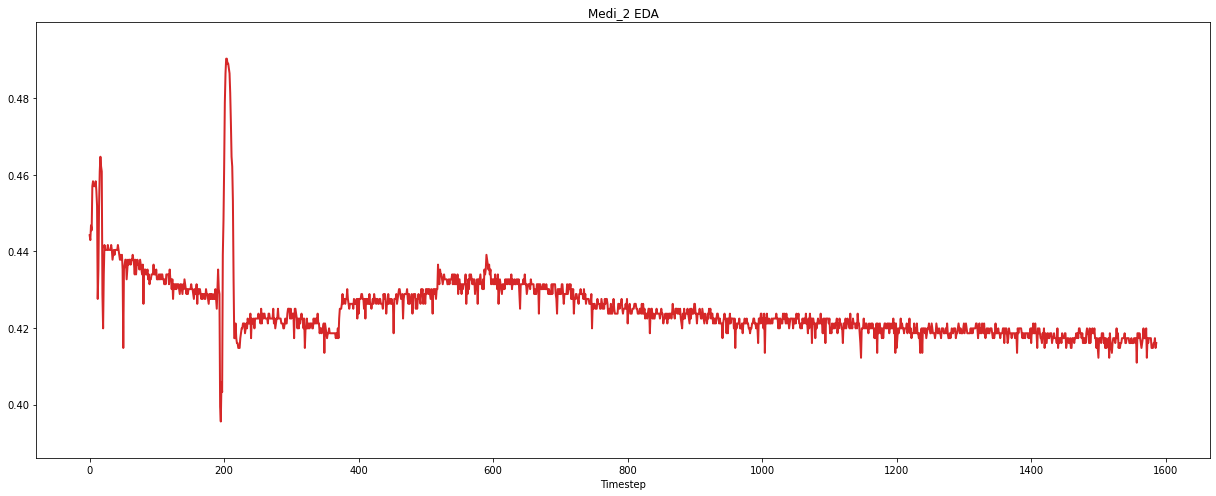

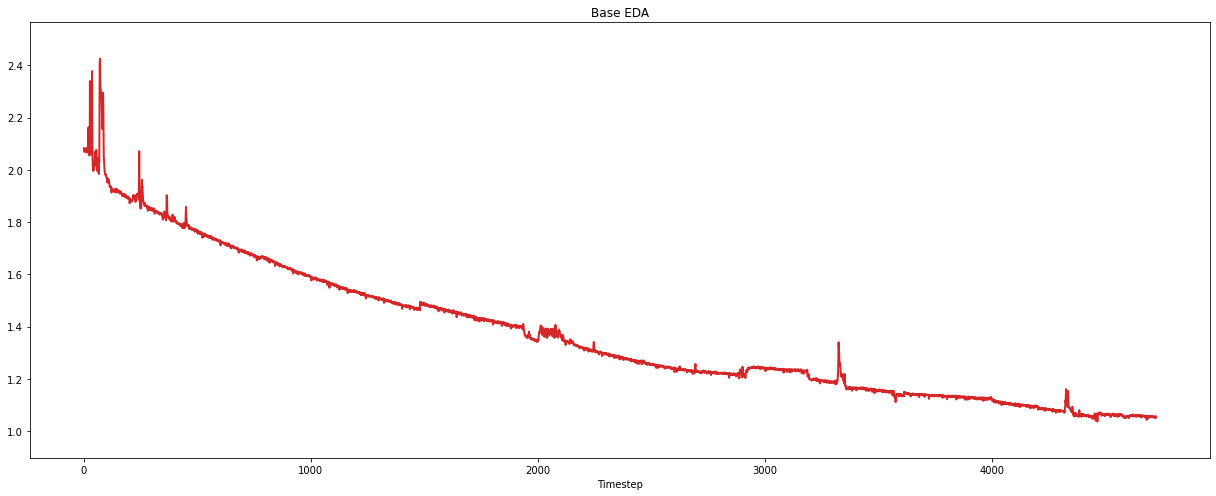

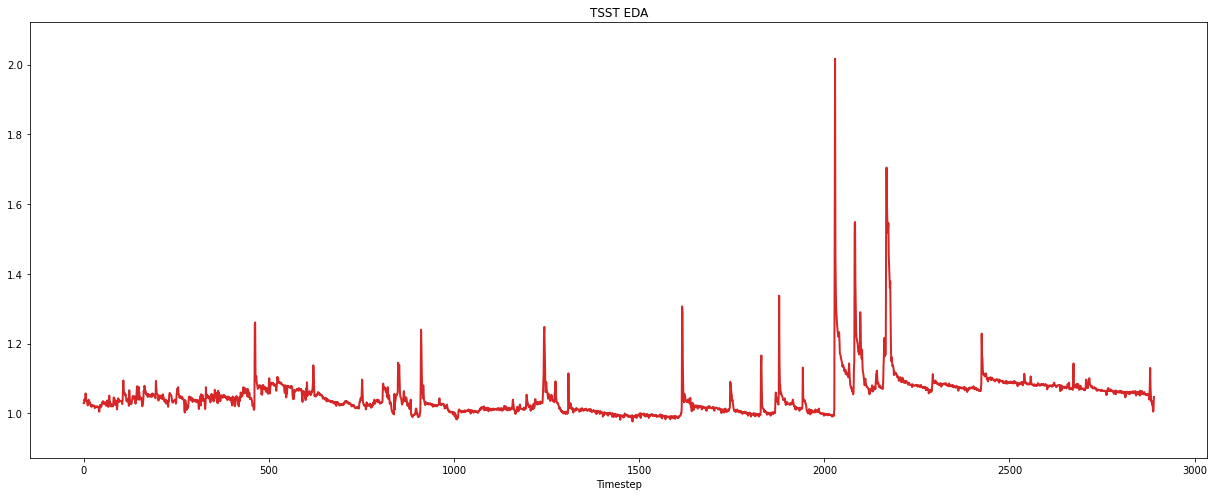

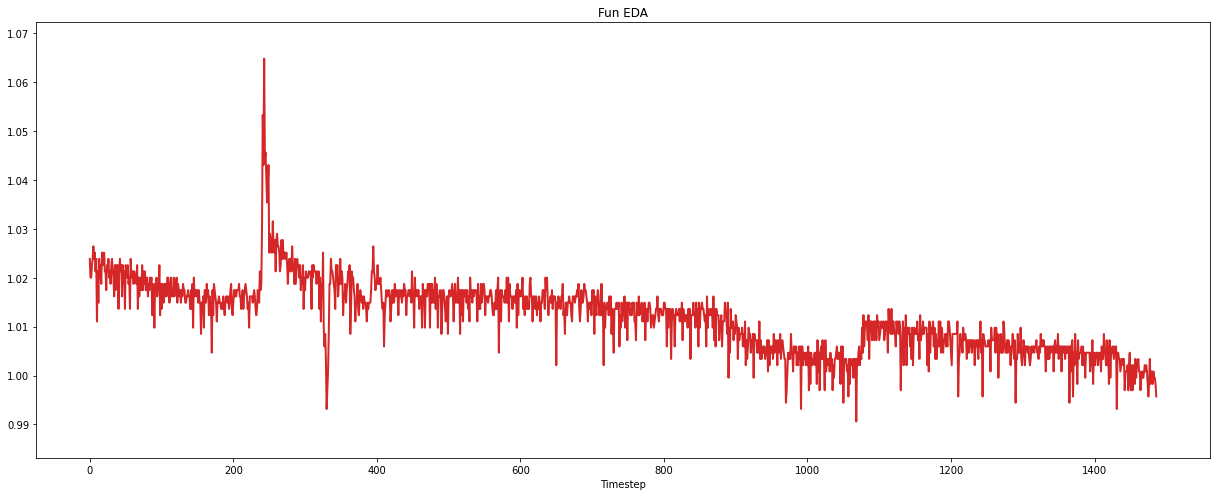

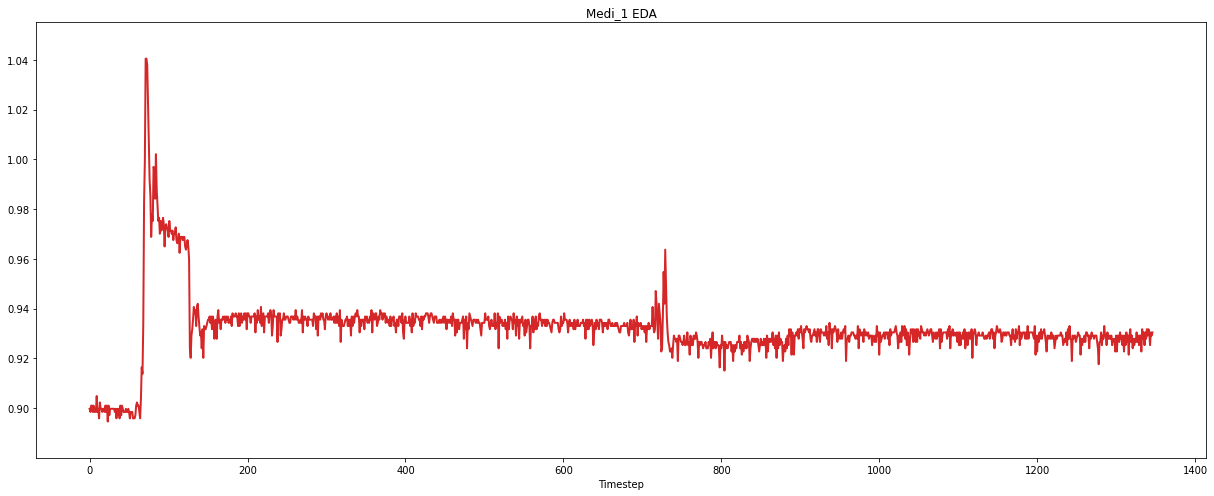

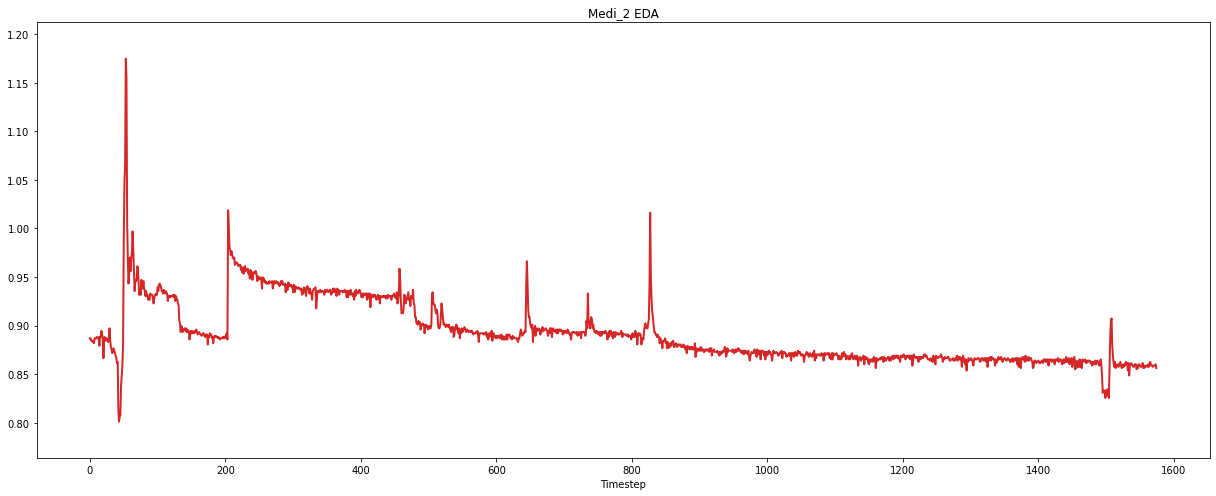

In [40]:
# VISUALIZE EDA DATA
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)


subject_indices = list(range(2, 12)) + list(range(13, 18))
subject_indices = [str(i) for i in subject_indices]

# locations = [dr.WESADKeys.CHEST, dr.WESADKeys.WRIST]
locations = [dr.WESADKeys.WRIST]
chest_signals = [
    dr.Signals.ACC, dr.Signals.ECG, dr.Signals.EDA, dr.Signals.EMG, "Resp", "Temp"
]
wrist_signals = [
    dr.Signals.ACC, dr.Signals.BVP, dr.Signals.EDA, dr.Signals.TEMP
]

phase_label_dict = {
    1: dr.Phases.BASE,
    2: dr.Phases.TSST,
    3: dr.Phases.FUN,
    4: [dr.Phases.MEDI_1, dr.Phases.MEDI_2]
}

phases = dr.Phases.PHASE_ORDER
location = "wrist"

signal = dr.Signals.EDA
for subject in subject_indices:
    data = dr.get_participant_data(subject)
    
    if location == "wrist":
        sr = dr.FS_DICT["wrist"][signal]
    time_segments = get_time_segments(subject, sr)
    signal_data = data["signal"][location][signal]
    for label in list(phase_label_dict.keys()):
        phase = phase_label_dict[label]
        if label == 4:  # 4 corresponds to MEDI 1 and MEDI 2; includes 2 time segment tuples
            columns_1 = [f"{location}_{signal}_{phase[0]}"]
            start = time_segments[label][0][0]
            end = time_segments[label][0][1]
            phase_data = signal_data[start:end]
            # phase_data = pd.DataFrame(data=phase_data, columns=columns_1)
            dt.plot_1d_data(phase_data, title=f"{phase[0]} {signal}")

            columns_2 = [f"{location}_{signal}_{phase[1]}"]
            start = time_segments[label][1][0]
            end = time_segments[label][1][1]
            phase_data = signal_data[start:end]
            # phase_data = pd.DataFrame(data=phase_data, columns=columns_2)
            dt.plot_1d_data(phase_data, title=f"{phase[1]} {signal}")
        else:
            columns = [f"{location}_{signal}_{phase}"]
            start = time_segments[label][0][0]
            end = time_segments[label][0][1]
            phase_data = signal_data[start:end]
            # phase_data = pd.DataFrame(data=phase_data, columns=columns)
            dt.plot_1d_data(phase_data, title=f"{phase} {signal}")